In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
from pathlib import Path
import shap
from scipy import stats

In [2]:
# Í∏∞Í≥ÑÌïôÏäµ ÎùºÏù¥Î∏åÎü¨Î¶¨
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# ÏãúÍ≥ÑÏó¥ Î∂ÑÏÑù ÎùºÏù¥Î∏åÎü¨Î¶¨
from prophet import Prophet
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# Îî•Îü¨Îãù ÎùºÏù¥Î∏åÎü¨Î¶¨
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Permute, Reshape, Multiply, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

In [5]:
# Ïù∏Í≥º Ï∂îÎ°† Î∞è Î≥ÄÌôîÏ†ê ÌÉêÏßÄ
from causalimpact import CausalImpact
import ruptures as rpt

In [6]:
# Í≤ΩÍ≥† Î©îÏãúÏßÄ Î¨¥Ïãú Î∞è pandas ÏÑ§Ï†ï
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [7]:
# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
from matplotlib import font_manager, rc
try:
    # Windows
    font_path = "C:/Windows/Fonts/malgun.ttf"
    if os.path.exists(font_path):
        font_name = font_manager.FontProperties(fname=font_path).get_name()
        rc('font', family=font_name)
    else:
        # Mac
        rc('font', family='AppleGothic')
except:
    pass
plt.rcParams['axes.unicode_minus'] = False

In [8]:
# Ï†ÑÏó≠ ÏÉâÏÉÅ ÌåîÎ†àÌä∏ ÏÑ§Ï†ï
COLORS = {
    'prophet': '#3498db',
    'arima': '#2ecc71',
    'xgboost': '#e74c3c',
    'lstm': '#9b59b6',
    'trend': '#f39c12',
    'ensemble': '#34495e'
}

In [9]:
def create_output_folders():
    """Ï∂úÎ†• Ìè¥Îçî ÏÉùÏÑ± (Ï∂îÍ∞Ä Ìè¥Îçî Ìè¨Ìï®)"""
    folders = [
        'forecast_results_2',
        'forecast_results_2/graphs',
        'forecast_results_2/individual_forecasts',
        'forecast_results_2/comparison',
        'forecast_results_2/reports',
        'forecast_results_2/feature_importance',
        'forecast_results_2/diagnostics',
        'forecast_results_2/performance',
        'forecast_results_2/interpretability',
        'forecast_results_2/interpretability/causal_impact',
        'forecast_results_2/interpretability/shap',
        'forecast_results_2/interpretability/attention'
    ]
    
    for folder in folders:
        Path(folder).mkdir(parents=True, exist_ok=True)
    
    print("Ï∂úÎ†• Ìè¥ÎçîÍ∞Ä ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§:")
    for folder in folders[:8]:  # Ï£ºÏöî Ìè¥ÎçîÎßå ÌëúÏãú
        print(f"  - {folder}/")
    print("  - ... (interpretability ÌïòÏúÑ Ìè¥Îçî Ìè¨Ìï®)")
    
    return folders[0]  # Î©îÏù∏ Ìè¥Îçî Í≤ΩÎ°ú Î∞òÌôò

# ÏàòÏ†ïÎêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨

In [10]:
def load_and_preprocess_data_fixed(file_path):
    """ÏàòÏ†ïÎêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨"""
    print(f"\nÌååÏùº Î°úÎìú Ï§ë: {file_path}")
    
    df_raw = pd.read_excel(file_path, header=None)
    print(f"ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ shape: {df_raw.shape}")
    
    dates = []
    for col_idx in range(2, len(df_raw.columns)):
        date_val = df_raw.iloc[0, col_idx]
        if pd.notna(date_val):
            dates.append(pd.to_datetime(date_val))
    
    print(f"ÎÇ†Ïßú Í∞úÏàò: {len(dates)}")
    print(f"ÎÇ†Ïßú Î≤îÏúÑ: {dates[0]} ~ {dates[-1]}")
    
    data_dict = {}
    
    for row_idx in range(1, len(df_raw)):
        country = df_raw.iloc[row_idx, 0]
        variable = df_raw.iloc[row_idx, 1]
        
        if pd.notna(country) and pd.notna(variable):
            key = f"{country}_{variable}"
            
            values = []
            for col_idx in range(2, 2 + len(dates)):
                val = df_raw.iloc[row_idx, col_idx]
                if pd.isna(val) or val == '-' or val == '':
                    values.append(np.nan)
                else:
                    try:
                        values.append(float(val))
                    except:
                        values.append(np.nan)
            
            series = pd.Series(values, index=dates, name=key)
            data_dict[key] = series
    
    df_wide = pd.DataFrame(data_dict)
    
    export_cols = [col for col in df_wide.columns if 'ÏàòÏ∂úÏï°' in col]
    print(f"\nÏàòÏ∂úÏï° Ïª¨Îüº: {export_cols}")
    
    return df_wide

# Í∞úÏÑ†Îêú Ïó∞Í∞Ñ‚ÜíÏõîÎ≥Ñ Î≥ÄÌôò (ÎÖ∏Ïù¥Ï¶à ÏµúÏÜåÌôî)

In [11]:
def convert_yearly_to_monthly_improved(df_yearly, seasonal_patterns):
    """Í∞úÏÑ†Îêú Ïó∞Í∞Ñ‚ÜíÏõîÎ≥Ñ Î≥ÄÌôò (ÎÖ∏Ïù¥Ï¶à ÏµúÏÜåÌôî)"""
    
    valid_cols = [col for col in df_yearly.columns if df_yearly[col].notna().any()]
    
    if not valid_cols:
        return pd.DataFrame()
    
    first_col_data = df_yearly[valid_cols[0]].dropna()
    start_year = first_col_data.index[0].year
    end_year = first_col_data.index[-1].year
    
    print(f"\nÏó∞Í∞Ñ‚ÜíÏõîÎ≥Ñ Î≥ÄÌôò: {start_year}-{end_year}")
    
    monthly_index = pd.date_range(
        start=f'{start_year}-01-01',
        end=f'{end_year}-12-31',
        freq='M'
    )
    
    df_monthly = pd.DataFrame(index=monthly_index, columns=df_yearly.columns)
    
    for col in valid_cols:
        yearly_values = df_yearly[col].dropna()
        
        if len(yearly_values) == 0:
            continue
            
        country = col.split('_')[0]
        seasonal_pattern = get_variable_seasonality(col, country, seasonal_patterns)
        
        for idx, annual_value in yearly_values.items():
            year = idx.year
            monthly_values = annual_value * seasonal_pattern / seasonal_pattern.sum()
            
            for month in range(1, 13):
                target_date = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(0)
                if target_date in df_monthly.index:
                    df_monthly.loc[target_date, col] = monthly_values[month]
        
        # Ïä§Î¨¥Îî©ÏùÑ ÏµúÏÜåÌôî (ÏõêÎ≥∏ Ìå®ÌÑ¥ Ïú†ÏßÄ)
        if df_monthly[col].notna().sum() > 0:
            df_monthly[col] = df_monthly[col].rolling(window=2, center=True, min_periods=1).mean()
    
    return df_monthly

# Î≥ÄÏàòÎ≥Ñ Í≥ÑÏ†àÏÑ± Ìå®ÌÑ¥

In [12]:
def get_variable_seasonality(col, country, seasonal_patterns):
    """Î≥ÄÏàòÎ≥Ñ Í≥ÑÏ†àÏÑ± Ìå®ÌÑ¥ (Íµ≠Í∞ÄÎ™Ö ÌïúÍ∏Ä ÎåÄÏùë)"""
    default_export_pattern = pd.Series({
        1: 0.95, 2: 0.92, 3: 1.05, 4: 1.02, 5: 1.03, 6: 1.08,
        7: 0.98, 8: 0.96, 9: 1.04, 10: 1.03, 11: 1.05, 12: 0.99
    })
    
    # Íµ≠Í∞ÄÎ™Ö Îß§Ìïë (ÏòÅÎ¨∏ -> ÌïúÍ∏Ä)
    country_name_map = {
        'USA': 'ÎØ∏Íµ≠',
        'CHN': 'Ï§ëÍµ≠', 
        'JPN': 'ÏùºÎ≥∏',
        'ÎØ∏Íµ≠': 'ÎØ∏Íµ≠',
        'Ï§ëÍµ≠': 'Ï§ëÍµ≠',
        'ÏùºÎ≥∏': 'ÏùºÎ≥∏'
    }
    
    # Îß§ÌïëÎêú Íµ≠Í∞ÄÎ™ÖÏúºÎ°ú Í≤ÄÏÉâ
    mapped_country = country_name_map.get(country, country)
    
    if mapped_country in seasonal_patterns and 'export' in seasonal_patterns[mapped_country]:
        return seasonal_patterns[mapped_country]['export']
    
    return default_export_pattern

# Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï

In [13]:
def check_stationarity(timeseries, name="Series"):
    """Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï (ADF Test)"""
    print(f"\n{name} Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï:")
    
    # ADF Í≤ÄÏ†ï
    result = adfuller(timeseries.dropna())
    print(f'  ADF ÌÜµÍ≥ÑÎüâ: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')
    print(f'  ÏûÑÍ≥ÑÍ∞í:')
    for key, value in result[4].items():
        print(f'    {key}: {value:.4f}')
    
    if result[1] <= 0.05:
        print(f"  ‚Üí Í≤∞Í≥º: Ï†ïÏÉÅ ÏãúÍ≥ÑÏó¥ (p-value ‚â§ 0.05)")
        return True
    else:
        print(f"  ‚Üí Í≤∞Í≥º: ÎπÑÏ†ïÏÉÅ ÏãúÍ≥ÑÏó¥ (p-value > 0.05), Ï∞®Î∂Ñ ÌïÑÏöî")
        return False

# Ï∞®Î∂Ñ(Ï†ïÏÉÅÌôî)

In [14]:
def make_stationary(timeseries, max_diff=2):
    """ÏãúÍ≥ÑÏó¥ÏùÑ Ï†ïÏÉÅÌôî (Ï∞®Î∂Ñ Ï†ÅÏö©)"""
    diff_count = 0
    ts = timeseries.copy()
    
    while diff_count < max_diff:
        if check_stationarity(ts, f"Ï∞®Î∂Ñ {diff_count}Ìöå"):
            return ts, diff_count
        
        diff_count += 1
        ts = ts.diff().dropna()
        print(f"  {diff_count}Ï∞® Ï∞®Î∂Ñ Ï†ÅÏö©")
    
    return ts, diff_count

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ

In [15]:
def prepare_data_for_models(data, export_col):
    """Î™®Îç∏Î≥ÑÎ°ú Ï†ÅÏ†àÌïú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ"""
    
    # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞
    original_data = data[export_col].copy()
    
    # Î°úÍ∑∏ Î≥ÄÌôò (Î∂ÑÏÇ∞ ÏïàÏ†ïÌôî)
    log_data = np.log1p(original_data)
    
    # Ï∞®Î∂Ñ Îç∞Ïù¥ÌÑ∞ (Ï†ïÏÉÅÏÑ± ÌôïÎ≥¥)
    diff_data = log_data.diff().dropna()
    seasonal_diff_data = log_data.diff(12).dropna()
    
    # Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï
    print("\nÎç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï:")
    print("-" * 40)
    
    is_original_stationary = check_stationarity(original_data, "1. ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞")
    is_log_stationary = check_stationarity(log_data, "2. Î°úÍ∑∏ Î≥ÄÌôò Îç∞Ïù¥ÌÑ∞")
    is_diff_stationary = check_stationarity(diff_data, "3. 1Ï∞® Ï∞®Î∂Ñ Îç∞Ïù¥ÌÑ∞")
    
    return {
        'original': original_data,
        'log': log_data,
        'diff': diff_data,
        'seasonal_diff': seasonal_diff_data,
        'is_stationary': is_original_stationary,
        'diff_order': 0 if is_original_stationary else (0 if is_log_stationary else 1)
    }

# ÏãúÍ≥ÑÏó¥ Î∂ÑÌï¥ ÏãúÍ∞ÅÌôî

In [16]:
def plot_time_series_decomposition(data, export_col, country, save_folder):
    """ÏãúÍ≥ÑÏó¥ Î∂ÑÌï¥ ÏãúÍ∞ÅÌôî"""
    
    try:
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        
        # ÏãúÍ≥ÑÏó¥ Î∂ÑÌï¥
        decomposition = seasonal_decompose(data[export_col].dropna(), model='multiplicative', period=12)
        
        # ÏõêÎ≥∏
        axes[0].plot(data[export_col], label='Original', color='black')
        axes[0].set_title(f'{country} ÏàòÏ∂úÏï° ÏãúÍ≥ÑÏó¥ Î∂ÑÌï¥', fontsize=16, fontweight='bold')
        axes[0].set_ylabel('Original')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Ìä∏Î†åÎìú
        axes[1].plot(decomposition.trend, label='Trend', color='blue')
        axes[1].set_ylabel('Trend')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Í≥ÑÏ†àÏÑ±
        axes[2].plot(decomposition.seasonal, label='Seasonal', color='green')
        axes[2].set_ylabel('Seasonal')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # ÏûîÏ∞®
        axes[3].plot(decomposition.resid, label='Residual', color='red')
        axes[3].set_ylabel('Residual')
        axes[3].set_xlabel('Date')
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Ï†ÄÏû•
        filename = os.path.join(save_folder, 'diagnostics', f'{country}_decomposition.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  ‚Üí ÏãúÍ≥ÑÏó¥ Î∂ÑÌï¥ Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
        plt.close()
    except Exception as e:
        print(f"  ÏãúÍ≥ÑÏó¥ Î∂ÑÌï¥ ÏãúÍ∞ÅÌôî Ïã§Ìå®: {str(e)}")

# ACF/PACF ÌîåÎ°Ø

In [17]:
def plot_acf_pacf(data, export_col, country, save_folder):
    """ACF/PACF ÌîåÎ°Ø"""
    
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞
        plot_acf(data[export_col].dropna(), ax=axes[0, 0], lags=40)
        axes[0, 0].set_title('ACF - ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞')
        
        plot_pacf(data[export_col].dropna(), ax=axes[0, 1], lags=40)
        axes[0, 1].set_title('PACF - ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞')
        
        # Ï∞®Î∂Ñ Îç∞Ïù¥ÌÑ∞
        diff_data = data[export_col].diff().dropna()
        plot_acf(diff_data, ax=axes[1, 0], lags=40)
        axes[1, 0].set_title('ACF - 1Ï∞® Ï∞®Î∂Ñ Îç∞Ïù¥ÌÑ∞')
        
        plot_pacf(diff_data, ax=axes[1, 1], lags=40)
        axes[1, 1].set_title('PACF - 1Ï∞® Ï∞®Î∂Ñ Îç∞Ïù¥ÌÑ∞')
        
        plt.suptitle(f'{country} ÏûêÍ∏∞ÏÉÅÍ¥Ä Î∂ÑÏÑù', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        # Ï†ÄÏû•
        filename = os.path.join(save_folder, 'diagnostics', f'{country}_acf_pacf.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  ‚Üí ACF/PACF Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
        plt.close()
    except Exception as e:
        print(f"  ACF/PACF ÏãúÍ∞ÅÌôî Ïã§Ìå®: {str(e)}")

# Íµ¨Ï°∞Ï†Å Î≥ÄÌôîÏ†ê

In [18]:
def detect_structural_break(data, min_size=12):
    """Íµ¨Ï°∞Ï†Å Î≥ÄÌôîÏ†ê ÌÉêÏßÄ"""
    try:
        signal = data.values
        algo = rpt.Pelt(model="rbf", min_size=min_size).fit(signal)
        change_points = algo.predict(pen=10)
        return change_points[:-1]  # ÎßàÏßÄÎßâÏùÄ ÎÅùÏ†êÏù¥ÎØÄÎ°ú Ï†úÏô∏
    except:
        return []

# Íµ¨Ï°∞Ï†Å Î≥ÄÌôîÏ†ê Í∏∞Ï§ÄÏúºÎ°ú Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨

In [19]:
def split_by_structural_break(df, export_col, country):
    """Íµ¨Ï°∞Ï†Å Î≥ÄÌôî Í∏∞Ï§ÄÏúºÎ°ú Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨"""
    
    # Î≥ÄÌôîÏ†ê ÌÉêÏßÄ
    change_points = detect_structural_break(df[export_col].dropna())
    
    # 2021ÎÖÑ Í∑ºÏ≤òÏùò Î≥ÄÌôîÏ†ê Ï∞æÍ∏∞
    target_date = pd.Timestamp('2021-01-01')
    split_date = target_date
    
    if change_points:
        for cp in change_points:
            cp_date = df.index[cp]
            if abs((cp_date - target_date).days) < 365:  # 1ÎÖÑ Ïù¥ÎÇ¥
                split_date = cp_date
                break
    
    print(f"\n{country} Íµ¨Ï°∞Ï†Å Î≥ÄÌôîÏ†ê: {split_date.strftime('%Y-%m')}")
    
    pre_break = df[df.index < split_date]
    post_break = df[df.index >= split_date]
    
    # ÌÜµÍ≥Ñ ÎπÑÍµê
    pre_mean = pre_break[export_col].mean()
    post_mean = post_break[export_col].mean()
    growth = (post_mean / pre_mean - 1) * 100
    
    print(f"  - Pre-break: {len(pre_break)}Í∞úÏõî, ÌèâÍ∑† ${pre_mean/1e6:.1f}M")
    print(f"  - Post-break: {len(post_break)}Í∞úÏõî, ÌèâÍ∑† ${post_mean/1e6:.1f}M")
    print(f"  - ÏÑ±Ïû•Î•†: {growth:+.1f}%")
    
    return pre_break, post_break, split_date

# Prophet

In [20]:
def prophet_model(data, export_col, periods=6):
    """Prophet Î™®Îç∏ (Ïô∏Î∂Ä Î≥ÄÏàò Ìè¨Ìï®, NaN Ï≤òÎ¶¨ Í∞úÏÑ†)"""
    
    # Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï
    print("  Prophet Ï†ÑÏ≤òÎ¶¨ Ï§ë...")
    is_stationary = check_stationarity(data[export_col], "Prophet ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞")
    
    # Ï†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥Î©¥ Ï∞®Î∂Ñ ÏóÜÏù¥ ÏßÑÌñâ
    if is_stationary:
        print("  ‚Üí Ïù¥ÎØ∏ Ï†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥ÎØÄÎ°ú Ï∞®Î∂Ñ ÏóÜÏù¥ ÏßÑÌñâ")
    
    df_prophet = pd.DataFrame({
        'ds': data.index,
        'y': data[export_col].values
    })
    
    # Î°úÍ∑∏ Î≥ÄÌôò (ÏïàÏ†ïÌôî)
    df_prophet['y'] = np.log1p(df_prophet['y'])
    print("  Î°úÍ∑∏ Î≥ÄÌôò Ï†ÅÏö© (Î∂ÑÏÇ∞ ÏïàÏ†ïÌôî)")
    
    # === Ïô∏Î∂Ä ÌöåÍ∑ÄÎ≥ÄÏàò Ï∂îÍ∞Ä (NaN Ï≤òÎ¶¨ Í∞ïÌôî) ===
    country_name = export_col.split('_')[0]
    extra_regressors = []
    
    # Íµ≠Í∞ÄÎ≥Ñ Í≤ΩÏ†ú ÏßÄÌëú
    economic_vars = ['GDP', 'CPI', 'CLI', 'ÌôòÏú®', 'ÌïúÎ•òÏã¨Î¶¨ÏßÄÏàò']
    for var in economic_vars:
        col_name = f'{country_name}_{var}'
        if col_name in data.columns:
            # NaNÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
            if data[col_name].isna().all():
                print(f"    - {var}: Î™®Îì† Í∞íÏù¥ NaN, Ï†úÏô∏")
                continue
            
            # Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ - Î≥¥Í∞ÑÎ≤ï ÏÇ¨Ïö©
            values = data[col_name].copy()
            
            # ÏïûÎí§ Ï±ÑÏö∞Í∏∞ Ï†ÑÏóê Î≥¥Í∞Ñ
            if values.notna().sum() > 2:  # ÏµúÏÜå 2Í∞ú Ïù¥ÏÉÅÏùò Ïú†Ìö®Í∞íÏù¥ ÏûàÏùÑ Îïå
                values = values.interpolate(method='linear', limit_direction='both')
            
            # Í∑∏ÎûòÎèÑ ÎÇ®ÏùÄ NaNÏùÄ ÌèâÍ∑†Í∞íÏúºÎ°ú
            if values.isna().any():
                mean_val = values.mean()
                if pd.notna(mean_val):
                    values = values.fillna(mean_val)
                else:
                    print(f"    - {var}: Ïú†Ìö®Ìïú Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå, Ï†úÏô∏")
                    continue
            
            # ÌëúÏ§ÄÌôî
            if values.std() > 0:
                df_prophet[var] = (values - values.mean()) / values.std()
                extra_regressors.append(var)
                print(f"    - {var} Ï∂îÍ∞Ä (NaN Ï≤òÎ¶¨ ÏôÑÎ£å)")
            else:
                print(f"    - {var}: Î≥ÄÎèô ÏóÜÏùå, Ï†úÏô∏")
    
    # Í∏ÄÎ°úÎ≤å ÏßÄÌëú
    global_vars = ['Ïú†Í∞Ä', 'ÏõêÏûêÏû¨Í∞ÄÍ≤©']
    for var in global_vars:
        for col in data.columns:
            if var in col and not col.startswith(country_name):  # Íµ≠Í∞ÄÎ≥ÑÏù¥ ÏïÑÎãå Í∏ÄÎ°úÎ≤å Î≥ÄÏàò
                values = data[col].copy()
                
                if values.isna().all():
                    continue
                
                # Î≥¥Í∞Ñ Î∞è Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
                if values.notna().sum() > 2:
                    values = values.interpolate(method='linear', limit_direction='both')
                values = values.fillna(values.mean())
                
                if values.notna().all() and values.std() > 0:
                    df_prophet[var] = (values - values.mean()) / values.std()
                    extra_regressors.append(var)
                    print(f"    - {var} Ï∂îÍ∞Ä")
                break
    
    print(f"  Ïô∏Î∂Ä ÌöåÍ∑ÄÎ≥ÄÏàò: {len(extra_regressors)}Í∞ú")
    
    # Prophet Î™®Îç∏ ÏÑ§Ï†ï
    model = Prophet(
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=10,
        yearly_seasonality=True,
        weekly_seasonality=False,
        interval_width=0.95,
        daily_seasonality=False
    )
    
    # Ïô∏Î∂Ä ÌöåÍ∑ÄÎ≥ÄÏàò Îì±Î°ù
    for regressor in extra_regressors:
        try:
            model.add_regressor(regressor, mode='additive')  # multiplicative ÎåÄÏã† additive ÏÇ¨Ïö©
        except Exception as e:
            print(f"    {regressor} Îì±Î°ù Ïã§Ìå®: {str(e)}")
    
    model.add_country_holidays(country_name='KR')
    print("  ÌïúÍµ≠ Í≥µÌú¥Ïùº Î∞òÏòÅ")
    
    # Î™®Îç∏ ÌïôÏäµ
    try:
        model.fit(df_prophet)
    except Exception as e:
        print(f"  Prophet ÌïôÏäµ Ïã§Ìå®: {str(e)}")
        # Ïô∏Î∂Ä Î≥ÄÏàò ÏóÜÏù¥ Îã§Ïãú ÏãúÎèÑ
        print("  Ïô∏Î∂Ä Î≥ÄÏàò ÏóÜÏù¥ Ïû¨ÏãúÎèÑ...")
        model = Prophet(
            changepoint_prior_scale=0.1,
            seasonality_prior_scale=10,
            yearly_seasonality=True,
            weekly_seasonality=False,
            interval_width=0.95
        )
        model.add_country_holidays(country_name='KR')
        model.fit(df_prophet[['ds', 'y']])
        extra_regressors = []
    
    # ÎØ∏Îûò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
    future = model.make_future_dataframe(periods=periods, freq='M')
    
    # ÎØ∏Îûò Ïô∏Î∂Ä Î≥ÄÏàò Í∞í ÏòàÏ∏°
    for regressor in extra_regressors:
        if regressor in df_prophet.columns:
            # Í∞ÑÎã®Ìûà ÎßàÏßÄÎßâ Í∞í ÏÇ¨Ïö©
            last_value = df_prophet[regressor].iloc[-1]
            future.loc[future.index[-periods:], regressor] = last_value
    
    # ÏòàÏ∏°
    forecast = model.predict(future)
    
    # Ïó≠Î°úÍ∑∏ Î≥ÄÌôò
    predictions = np.expm1(forecast['yhat'].tail(periods).values)
    lower = np.expm1(forecast['yhat_lower'].tail(periods).values)
    upper = np.expm1(forecast['yhat_upper'].tail(periods).values)
    
    # Î≥ÄÌôîÏ†ê Ï†ïÎ≥¥ Ï∂úÎ†•
    if len(model.changepoints) > 0:
        print(f"  ÌÉêÏßÄÎêú Î≥ÄÌôîÏ†ê: {len(model.changepoints)}Í∞ú")
        recent_changepoints = model.changepoints[-3:]  # ÏµúÍ∑º 3Í∞ú
        for cp in recent_changepoints:
            print(f"    - {cp.strftime('%Y-%m')}")
    
    return predictions, (lower, upper), model

# Auto_arima

In [21]:
def auto_arima_model(data, export_col, periods=6):
    """Auto ARIMA (Ï†ïÏÉÅÏÑ± ÌôïÏù∏ ÌõÑ Ï∞®Î∂Ñ Í≤∞Ï†ï)"""
    
    # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞
    y_original = data[export_col].values
    
    # Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï
    is_stationary = check_stationarity(data[export_col], "ÏõêÎ≥∏ ÏãúÍ≥ÑÏó¥")
    
    # Î°úÍ∑∏ Î≥ÄÌôò (Î∂ÑÏÇ∞ ÏïàÏ†ïÌôî)
    y = np.log1p(y_original)
    
    # Ï†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥Î©¥ Ï∞®Î∂Ñ Ï∞®ÏàòÎ•º 0ÏúºÎ°ú Ï†úÌïú
    if is_stationary:
        print("  ‚Üí Ïù¥ÎØ∏ Ï†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥ÎØÄÎ°ú Ï∞®Î∂Ñ Ï†úÌïú (d=0)")
        d_max = 0
        D_max = 0
    else:
        print("  ‚Üí ÎπÑÏ†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥ÎØÄÎ°ú ÏûêÎèô Ï∞®Î∂Ñ ÌÉêÏÉâ")
        d_max = 2
        D_max = 1
    
    # Auto ARIMAÍ∞Ä ÏûêÎèôÏúºÎ°ú Ï∞®Î∂Ñ Ï∞®Ïàò(d)Î•º Í≤∞Ï†ï
    print("  Auto ARIMA Î™®Îç∏ ÌÉêÏÉâ Ï§ë...")
    
    try:
        model = pm.auto_arima(
            y,
            start_p=0, start_q=0, max_p=3, max_q=3,
            seasonal=True, m=12,
            start_P=0, start_Q=0, max_P=2, max_Q=2,
            d=None if not is_stationary else 0,  # Ï†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥Î©¥ d=0
            D=None if not is_stationary else 0,  # Ï†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥Î©¥ D=0
            max_d=d_max,  # ÏµúÎåÄ Ï∞®Î∂Ñ Ï∞®Ïàò Ï†úÌïú
            max_D=D_max,
            trace=True,  # ÏßÑÌñâ ÏÉÅÌô© ÌëúÏãú
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True,
            n_jobs=1,  # Î≥ëÎ†¨ Ï≤òÎ¶¨ ÎπÑÌôúÏÑ±Ìôî (ÏïàÏ†ïÏÑ±)
            maxiter=50  # ÏµúÎåÄ Î∞òÎ≥µ ÌöüÏàò Ï†úÌïú
        )
    except Exception as e:
        print(f"  Auto ARIMA Ïã§Ìå®: {str(e)}")
        print("  Í∞ÑÎã®Ìïú ARIMA(1,1,1)(0,1,1)[12] Î™®Îç∏ ÏÇ¨Ïö©")
        # Í∏∞Î≥∏ Î™®Îç∏ ÏÇ¨Ïö©
        from statsmodels.tsa.arima.model import ARIMA
        model = ARIMA(y, order=(1,1,1), seasonal_order=(0,1,1,12))
        model = model.fit()
        
        forecast = model.forecast(steps=periods)
        predictions = np.expm1(forecast)
        
        # Ïã†Î¢∞Íµ¨Í∞ÑÏùÄ Í∞ÑÎã®Ìûà ¬±10%Î°ú ÏÑ§Ï†ï
        lower = predictions * 0.9
        upper = predictions * 1.1
        
        return predictions, (lower, upper), model
    
    # ÏÑ†ÌÉùÎêú Î™®Îç∏ Ï†ïÎ≥¥ Ï∂úÎ†•
    print(f"  ÏÑ†ÌÉùÎêú Î™®Îç∏: {model.order} x {model.seasonal_order}")
    print(f"  AIC: {model.aic():.2f}")
    
    # ÏòàÏ∏°
    forecast, conf_int = model.predict(n_periods=periods, return_conf_int=True)
    
    # Ïó≠Î°úÍ∑∏ Î≥ÄÌôò
    predictions = np.expm1(forecast)
    lower = np.expm1(conf_int[:, 0])
    upper = np.expm1(conf_int[:, 1])
    
    return predictions, (lower, upper), model

# LSTM

In [22]:
def prepare_lstm_data(X, y, time_steps):
    """LSTMÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ"""
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

def attention_layer(inputs):
    """Attention Î©îÏª§ÎãàÏ¶ò Íµ¨ÌòÑ"""
    # inputs shape: (batch_size, time_steps, features)
    
    # Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Dense Î†àÏù¥Ïñ¥
    attention_weights = Dense(1, activation='tanh')(inputs)
    attention_weights = Dropout(0.1)(attention_weights)
    
    # SoftmaxÎ°ú Ï†ïÍ∑úÌôî
    attention_weights = Lambda(lambda x: K.softmax(x, axis=1))(attention_weights)
    
    # ÏûÖÎ†•Ïóê Í∞ÄÏ§ëÏπò Ï†ÅÏö©
    weighted_input = Multiply()([inputs, attention_weights])
    
    # ÏãúÍ∞Ñ Ï∂ïÏúºÎ°ú Ìï©ÏÇ∞
    output = Lambda(lambda x: K.sum(x, axis=1))(weighted_input)
    
    return output, attention_weights

def improved_lstm_model_with_attention(data, export_col, periods=6, time_steps=12):
    """Attention Î©îÏª§ÎãàÏ¶òÏù¥ Ìè¨Ìï®Îêú Í∞úÏÑ†Îêú LSTM Î™®Îç∏ (Í≤ΩÍ≥† ÏàòÏ†ï)"""
    
    print("  LSTM (with Attention) Ï†ÑÏ≤òÎ¶¨ Ï§ë...")
    
    # TensorFlow Í≤ΩÍ≥† ÏñµÏ†ú
    import tensorflow as tf
    tf.config.run_functions_eagerly(True)  # Eager execution ÌôúÏÑ±Ìôî
    
    try:
        # Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
        data_versions = prepare_data_for_models(data, export_col)
        
        # ÌäπÏÑ± ÏÉùÏÑ±
        features = pd.DataFrame(index=data.index)
        
        # Ï†ïÏÉÅÌôîÎêú ÌÉÄÍ≤ü (Î°úÍ∑∏ Î≥ÄÌôòÎßå, Ï∞®Î∂ÑÏùÄ ÌäπÏÑ±ÏúºÎ°ú)
        features['target'] = data_versions['log']
        features['target_diff'] = data_versions['diff']
        
        # ÏãúÍ∞Ñ ÌäπÏÑ±
        features['month'] = data.index.month
        features['year'] = data.index.year - 2000  # Ïä§ÏºÄÏùº Ï°∞Ï†ï
        features['month_sin'] = np.sin(2 * np.pi * features['month'] / 12)
        features['month_cos'] = np.cos(2 * np.pi * features['month'] / 12)
        
        # ÏßÄÏó∞ ÌäπÏÑ± (Î°úÍ∑∏ Î≥ÄÌôòÎêú Í∞í ÏÇ¨Ïö©)
        for lag in [1, 3, 6, 12]:
            features[f'lag_{lag}'] = features['target'].shift(lag)
        
        # Ïù¥Îèô ÌÜµÍ≥Ñ
        for window in [3, 6, 12]:
            features[f'rolling_mean_{window}'] = features['target'].rolling(window).mean()
            features[f'rolling_std_{window}'] = features['target'].rolling(window).std()
        
        # Í≤∞Ï∏°Ïπò Ï†úÍ±∞
        features = features.dropna()
        
        if len(features) < time_steps + 20:  # Ï∂©Î∂ÑÌïú Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
            print("  LSTM: Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±")
            return None, None, None
        
        # Train/Validation Î∂ÑÎ¶¨
        train_size = int(len(features) * 0.8)
        train_features = features[:train_size]
        val_features = features[train_size:]
        
        # ÌäπÏÑ±Í≥º ÌÉÄÍ≤ü Î∂ÑÎ¶¨ (Ï∞®Î∂Ñ ÎåÄÏã† ÏõêÎ≥∏ Î°úÍ∑∏Í∞í ÏòàÏ∏°)
        feature_cols = [col for col in features.columns if col not in ['target', 'target_diff']]
        X_train = train_features[feature_cols].values
        y_train = train_features['target'].values  # Î°úÍ∑∏ Î≥ÄÌôòÎêú ÏõêÎ≥∏Í∞í
        X_val = val_features[feature_cols].values
        y_val = val_features['target'].values
        
        # Ïä§ÏºÄÏùºÎßÅ
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_val_scaled = scaler_X.transform(X_val)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
        
        # LSTM Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
        X_train_lstm, y_train_lstm = prepare_lstm_data(X_train_scaled, y_train_scaled, time_steps)
        X_val_lstm, y_val_lstm = prepare_lstm_data(X_val_scaled, y_val_scaled, time_steps)
        
        if len(X_train_lstm) < 10 or len(X_val_lstm) < 5:
            print("  LSTM: ÏãúÌÄÄÏä§ Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±")
            return None, None, None
        
        # Î™®Îç∏ÏùÑ Ìï®Ïàò Î∞ñÏóêÏÑú Ìïú Î≤àÎßå Ï†ïÏùò
        tf.keras.backend.clear_session()  # Ïù¥Ï†Ñ Î™®Îç∏ ÌÅ¥Î¶¨Ïñ¥
        
        # AttentionÏù¥ Ìè¨Ìï®Îêú LSTM Î™®Îç∏ Íµ¨ÏÑ±
        input_layer = Input(shape=(time_steps, X_train.shape[1]))
        
        # LSTM Î†àÏù¥Ïñ¥
        lstm_out = LSTM(32, return_sequences=True)(input_layer)
        lstm_out = Dropout(0.2)(lstm_out)
        
        # Attention Î†àÏù¥Ïñ¥
        attention_out, attention_weights = attention_layer(lstm_out)
        
        # Dense Î†àÏù¥Ïñ¥
        dense_out = Dense(16, activation='relu')(attention_out)
        dense_out = Dropout(0.2)(dense_out)
        output = Dense(1)(dense_out)
        
        # Î™®Îç∏ ÏÉùÏÑ±
        model = Model(inputs=input_layer, outputs=output)
        
        # Attention Í∞ÄÏ§ëÏπòÎ•º Ï∂îÏ∂úÌïòÍ∏∞ ÏúÑÌïú Î≥ÑÎèÑ Î™®Îç∏
        attention_model = Model(inputs=input_layer, outputs=attention_weights)
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        # ÏΩúÎ∞±
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
        
        print("  LSTM ÌïôÏäµ Ï§ë...")
        history = model.fit(
            X_train_lstm, y_train_lstm,
            validation_data=(X_val_lstm, y_val_lstm),
            epochs=50,
            batch_size=16,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )
        
        # ÏòàÏ∏° Ï§ÄÎπÑ
        last_sequence = X_train_scaled[-time_steps:].copy()
        predictions = []
        
        # Attention Í∞ÄÏ§ëÏπò Ï†ÄÏû•Ïö©
        attention_weights_list = []
        
        # ÎØ∏Îûò ÏòàÏ∏° - Î∞∞ÏπòÎ°ú Ï≤òÎ¶¨ÌïòÏó¨ retracing Î∞©ÏßÄ
        all_sequences = []
        current_sequence = last_sequence.copy()
        
        for i in range(periods):
            all_sequences.append(current_sequence.copy())
            # Îã§Ïùå ÏãúÌÄÄÏä§ Ï§ÄÎπÑ (Í∞ÑÎã®Ìïú Î∞©Î≤ï)
            new_features = current_sequence[-1].copy()
            current_sequence = np.vstack([current_sequence[1:], new_features])
        
        # Î∞∞Ïπò ÏòàÏ∏°
        all_sequences = np.array(all_sequences)
        predictions_scaled = model.predict(all_sequences, verbose=0)
        attention_weights_batch = attention_model.predict(all_sequences, verbose=0)
        
        # Ïó≠Ïä§ÏºÄÏùºÎßÅ Î∞è Ïó≠Î°úÍ∑∏ Î≥ÄÌôò
        predictions = []
        for pred_scaled in predictions_scaled:
            y_pred_log = scaler_y.inverse_transform([[pred_scaled[0]]])[0, 0]
            y_pred = np.expm1(y_pred_log)
            predictions.append(y_pred)
        
        attention_weights_list = attention_weights_batch
        
        print(f"  LSTM (with Attention) ÏôÑÎ£å: ÌèâÍ∑† ${np.mean(predictions)/1e6:.1f}M")
        
        # Attention Í∞ÄÏ§ëÏπò ÏãúÍ∞ÅÌôîÏö© Îç∞Ïù¥ÌÑ∞
        attention_data = {
            'weights': np.array(attention_weights_list),
            'feature_names': feature_cols,
            'time_steps': time_steps
        }
        
        # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
        tf.keras.backend.clear_session()
        
        return np.array(predictions), model, attention_data
        
    except Exception as e:
        print(f"  LSTM (with Attention) Ïã§Ìå®: {str(e)}")
        tf.keras.backend.clear_session()
        return None, None, None

# XGBoost

In [23]:
def xgboost_model(train_data, test_data, export_col, periods=6):
    """XGBoost Î™®Îç∏ (Î™®Îì† Ïô∏Î∂Ä Î≥ÄÏàò Ìè¨Ìï®)"""
    
    print("  XGBoost Ï†ÑÏ≤òÎ¶¨ Ï§ë...")
    
    # ÌäπÏÑ± ÏÉùÏÑ±
    def create_features(df):
        df_features = pd.DataFrame(index=df.index)
        df_features['export'] = df[export_col]
        
        # Î°úÍ∑∏ Î≥ÄÌôò (Ï†ïÏÉÅÏÑ± Í∞úÏÑ†)
        df_features['export_log'] = np.log1p(df_features['export'])
        
        # ÏãúÍ∞Ñ ÌäπÏÑ±
        df_features['month'] = df.index.month
        df_features['year'] = df.index.year
        df_features['quarter'] = df.index.quarter
        df_features['dayofyear'] = df.index.dayofyear
        
        # ÏàúÌôò ÌäπÏÑ± (Í≥ÑÏ†àÏÑ± Ìè¨Ï∞©)
        df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
        df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
        
        # ÏßÄÏó∞ ÌäπÏÑ±
        for i in [1, 2, 3, 6, 12]:
            df_features[f'lag{i}'] = df_features['export_log'].shift(i)
        
        # Ïù¥Îèô ÌÜµÍ≥Ñ
        for window in [3, 6, 12]:
            df_features[f'rolling_mean_{window}'] = df_features['export_log'].rolling(window).mean()
            df_features[f'rolling_std_{window}'] = df_features['export_log'].rolling(window).std()
            df_features[f'rolling_max_{window}'] = df_features['export_log'].rolling(window).max()
            df_features[f'rolling_min_{window}'] = df_features['export_log'].rolling(window).min()
        
        # Ï∞®Î∂Ñ ÌäπÏÑ± (Ï†ïÏÉÅÏÑ±)
        df_features['diff1'] = df_features['export_log'].diff()
        df_features['diff12'] = df_features['export_log'].diff(12)  # Í≥ÑÏ†à Ï∞®Î∂Ñ
        
        # ÏÑ±Ïû•Î•†
        df_features['mom_growth'] = df_features['export'].pct_change()
        df_features['yoy_growth'] = df_features['export'].pct_change(12)
        
        # === Ï§ëÏöî: Î™®Îì† Ïô∏Î∂Ä Î≥ÄÏàò Ìè¨Ìï® ===
        country_name = export_col.split('_')[0]
        print(f"    {country_name} Ïô∏Î∂Ä Î≥ÄÏàò Ï∂îÍ∞Ä Ï§ë...")
        
        # Íµ≠Í∞ÄÎ≥Ñ Í≤ΩÏ†ú ÏßÄÌëú
        economic_vars = ['GDP', 'CPI', 'CLI', 'ÌôòÏú®', 'ÌïúÎ•òÏã¨Î¶¨ÏßÄÏàò']
        for var in economic_vars:
            col_name = f'{country_name}_{var}'
            if col_name in df.columns:
                # ÏõêÎ≥∏ Í∞í
                df_features[f'{var}'] = df[col_name]
                df_features[f'{var}_log'] = np.log1p(df[col_name])
                
                # ÏßÄÏó∞ Í∞í
                df_features[f'{var}_lag1'] = df[col_name].shift(1)
                df_features[f'{var}_lag3'] = df[col_name].shift(3)
                
                # Î≥ÄÌôîÏú®
                df_features[f'{var}_change'] = df[col_name].pct_change()
                df_features[f'{var}_change_3m'] = df[col_name].pct_change(3)
                
                # Ïù¥ÎèôÌèâÍ∑†
                df_features[f'{var}_ma3'] = df[col_name].rolling(3).mean()
                
                print(f"      - {var} Ï∂îÍ∞Ä ÏôÑÎ£å")
        
        # Í∏ÄÎ°úÎ≤å ÏßÄÌëú (Íµ≠Í∞Ä Í≥µÌÜµ)
        global_vars = ['Ïú†Í∞Ä', 'ÏõêÏûêÏû¨Í∞ÄÍ≤©']
        for var in global_vars:
            # Ï≤´ Î≤àÏß∏ Íµ≠Í∞ÄÏùò Í∏ÄÎ°úÎ≤å ÏßÄÌëú ÏÇ¨Ïö© (Î™®Îì† Íµ≠Í∞Ä ÎèôÏùº)
            for col in df.columns:
                if var in col:
                    df_features[f'{var}'] = df[col]
                    df_features[f'{var}_log'] = np.log1p(df[col])
                    df_features[f'{var}_lag1'] = df[col].shift(1)
                    df_features[f'{var}_change'] = df[col].pct_change()
                    print(f"      - {var} Ï∂îÍ∞Ä ÏôÑÎ£å")
                    break
        
        # ÏÉÅÌò∏ÏûëÏö© ÌäπÏÑ± (Ï§ëÏöî!)
        # ÌôòÏú® * Ïú†Í∞Ä = ÏàòÏûÖ ÎπÑÏö©
        if 'ÌôòÏú®' in df_features.columns and 'Ïú†Í∞Ä' in df_features.columns:
            df_features['import_cost_index'] = df_features['ÌôòÏú®'] * df_features['Ïú†Í∞Ä']
            df_features['import_cost_change'] = df_features['import_cost_index'].pct_change()
        
        # GDP ÎåÄÎπÑ ÏàòÏ∂ú ÎπÑÏ§ë
        if 'GDP' in df_features.columns:
            df_features['export_to_gdp'] = df_features['export'] / (df_features['GDP'] + 1)
        
        # ÌïúÎ•ò Ìö®Í≥º * ÏàòÏ∂ú ÏÉÅÌò∏ÏûëÏö©
        if 'ÌïúÎ•òÏã¨Î¶¨ÏßÄÏàò' in df_features.columns:
            df_features['hallyu_export_interaction'] = (
                df_features['ÌïúÎ•òÏã¨Î¶¨ÏßÄÏàò'] * df_features['export_log'].shift(1)
            )
        
        return df_features.dropna()
    
    # ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    train_features = create_features(train_data)
    
    if len(train_features) < 20:
        print("  XGBoost: Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±ÏúºÎ°ú Í∞ÑÎã®Ìïú Î™®Îç∏ ÏÇ¨Ïö©")
        return simple_trend_model(train_data, export_col, periods), None
    
    X_train = train_features.drop(['export', 'export_log'], axis=1)
    y_train = train_features['export_log']  # Î°úÍ∑∏ Î≥ÄÌôòÎêú ÌÉÄÍ≤ü
    
    print(f"  ÌäπÏÑ± Í∞úÏàò: {X_train.shape[1]} (Ïô∏Î∂Ä Î≥ÄÏàò Ìè¨Ìï®)")
    
    # Ïô∏Î∂Ä Î≥ÄÏàò Í¥ÄÎ†® ÌäπÏÑ± Í∞úÏàò ÌôïÏù∏
    external_features = [col for col in X_train.columns if any(
        var in col for var in ['GDP', 'CPI', 'CLI', 'ÌôòÏú®', 'ÌïúÎ•ò', 'Ïú†Í∞Ä', 'ÏõêÏûêÏû¨']
    )]
    print(f"  Ïô∏Î∂Ä Î≥ÄÏàò Í¥ÄÎ†® ÌäπÏÑ±: {len(external_features)}Í∞ú")
    
    # Ïä§ÏºÄÏùºÎßÅ
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Î™®Îç∏ ÌõàÎ†® (ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù Ìè¨Ìï®)
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        verbosity=0
    )
    
    model.fit(X_train_scaled, y_train)
    
    # ÌäπÏÑ± Ï§ëÏöîÎèÑ Ï∂úÎ†• (ÏÉÅÏúÑ 15Í∞úÎ°ú ÌôïÎåÄ)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    print("  Ï£ºÏöî ÌäπÏÑ± (ÏÉÅÏúÑ 15Í∞ú):")
    for _, row in feature_importance.iterrows():
        print(f"    - {row['feature']}: {row['importance']:.3f}")
    
    # Ïô∏Î∂Ä Î≥ÄÏàòÏùò Ï§ëÏöîÎèÑ Îî∞Î°ú Ï∂úÎ†•
    external_importance = feature_importance[
        feature_importance['feature'].str.contains('GDP|CPI|CLI|ÌôòÏú®|ÌïúÎ•ò|Ïú†Í∞Ä|ÏõêÏûêÏû¨')
    ]
    if len(external_importance) > 0:
        print("\n  Ïô∏Î∂Ä Î≥ÄÏàò Ï§ëÏöîÎèÑ:")
        for _, row in external_importance.iterrows():
            print(f"    - {row['feature']}: {row['importance']:.3f}")
    
    # ÌäπÏÑ± Ï§ëÏöîÎèÑÎ•º Ï†ÑÏó≠ Î≥ÄÏàòÏóê Ï†ÄÏû•
    global xgb_feature_importance
    xgb_feature_importance = feature_importance
    
    # ÏòàÏ∏°ÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    last_data = train_data.copy()
    predictions = []
    
    for i in range(periods):
        # ÎßàÏßÄÎßâ Îç∞Ïù¥ÌÑ∞Î°ú ÌäπÏÑ± ÏÉùÏÑ±
        future_features = create_features(last_data)
        X_future = future_features.drop(['export', 'export_log'], axis=1).tail(1)
        X_future_scaled = scaler.transform(X_future)
        
        # ÏòàÏ∏° (Î°úÍ∑∏ Í≥µÍ∞ÑÏóêÏÑú)
        pred_log = model.predict(X_future_scaled)[0]
        pred = np.expm1(pred_log)  # Ïó≠Î°úÍ∑∏ Î≥ÄÌôò
        predictions.append(pred)
        
        # Îã§Ïùå ÏòàÏ∏°ÏùÑ ÏúÑÌï¥ Îç∞Ïù¥ÌÑ∞ ÏóÖÎç∞Ïù¥Ìä∏
        next_date = last_data.index[-1] + pd.DateOffset(months=1)
        new_row = pd.DataFrame({export_col: [pred]}, index=[next_date])
        
        # Îã§Î•∏ Î≥ÄÏàòÎì§ ÏóÖÎç∞Ïù¥Ìä∏ (Í∞ÑÎã®Ìïú Ï∂îÏÑ∏ Ïô∏ÏÇΩ ÎòêÎäî Í≥ÑÏ†àÏÑ± Î∞òÏòÅ)
        for col in last_data.columns:
            if col != export_col:
                if 'GDP' in col:
                    # GDPÎäî Ïó∞Í∞Ñ ÏÑ±Ïû•Î•† Í∞ÄÏ†ï (Ïòà: 3%)
                    annual_growth = 0.03
                    monthly_growth = (1 + annual_growth) ** (1/12) - 1
                    new_row[col] = last_data[col].iloc[-1] * (1 + monthly_growth)
                elif 'CPI' in col:
                    # CPIÎäî ÏµúÍ∑º 3Í∞úÏõî ÌèâÍ∑† Ï¶ùÍ∞ÄÏú® ÏÇ¨Ïö©
                    recent_growth = last_data[col].pct_change().tail(3).mean()
                    new_row[col] = last_data[col].iloc[-1] * (1 + recent_growth)
                elif 'ÌôòÏú®' in col:
                    # ÌôòÏú®ÏùÄ ÏµúÍ∑º Í∞í Ïú†ÏßÄ (ÎòêÎäî ÏûëÏùÄ Î≥ÄÎèô)
                    new_row[col] = last_data[col].iloc[-1] * np.random.normal(1, 0.01)
                else:
                    # Í∏∞ÌÉÄ Î≥ÄÏàòÎäî ÏµúÍ∑º Ï∂îÏÑ∏ Î∞òÏòÅ
                    if len(last_data) >= 3:
                        recent_values = last_data[col].tail(3)
                        trend = (recent_values.iloc[-1] - recent_values.iloc[0]) / 2
                        new_row[col] = last_data[col].iloc[-1] + trend
                    else:
                        new_row[col] = last_data[col].iloc[-1]
        
        last_data = pd.concat([last_data, new_row])
    
    # SHAP Î∂ÑÏÑùÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
    shap_data = {
        'model': model,
        'X_train': X_train,
        'X_train_scaled': X_train_scaled,
        'scaler': scaler,
        'feature_names': X_train.columns.tolist()
    }
    
    return np.array(predictions), shap_data

# Ï∂îÏÑ∏(Trend) Î™®Îç∏

In [24]:
def simple_trend_model(data, export_col, periods=6):
    """Îã®ÏàúÌïòÏßÄÎßå ÏïàÏ†ïÏ†ÅÏù∏ Ï∂îÏÑ∏ Î™®Îç∏"""
    
    recent_data = data[export_col].tail(12)
    
    # 1. ÏÑ†Ìòï Ï∂îÏÑ∏
    x = np.arange(len(recent_data))
    y = recent_data.values
    z = np.polyfit(x, y, 1)
    trend_slope = z[0]
    
    # 2. ÏÑ±Ïû•Î•†
    if len(recent_data) >= 12:
        yoy_growth = (recent_data.iloc[-1] / recent_data.iloc[-12] - 1)
        monthly_growth = (1 + yoy_growth) ** (1/12) - 1
    else:
        monthly_growth = 0.02  # Í∏∞Î≥∏ 2%
    
    # 3. Í≥ÑÏ†àÏÑ± Î∞òÏòÅ
    seasonal_factors = []
    for i in range(1, 7):  # Îã§Ïùå 6Í∞úÏõî
        next_month = (recent_data.index[-1].month + i - 1) % 12 + 1
        # Í≥ºÍ±∞ Í∞ôÏùÄ ÏõîÏùò ÌèâÍ∑† Í≥ÑÏ†à ÏöîÏù∏
        same_month_data = data[export_col][data.index.month == next_month]
        if len(same_month_data) > 0:
            seasonal_factor = same_month_data.mean() / data[export_col].mean()
        else:
            seasonal_factor = 1.0
        seasonal_factors.append(seasonal_factor)
    
    # ÏòàÏ∏°
    last_value = recent_data.iloc[-1]
    predictions = []
    
    for i in range(1, periods + 1):
        # Ï∂îÏÑ∏ÏôÄ ÏÑ±Ïû•Î•† Í≤∞Ìï©
        trend_pred = last_value + trend_slope * i
        growth_pred = last_value * (1 + monthly_growth) ** i
        
        # Í∞ÄÏ§ë ÌèâÍ∑†
        base_pred = trend_pred * 0.6 + growth_pred * 0.4
        
        # Í≥ÑÏ†àÏÑ± Ï†ÅÏö©
        seasonal_pred = base_pred * seasonal_factors[i-1]
        
        predictions.append(seasonal_pred)
    
    return np.array(predictions)

# ÏòàÏ∏°Í∞í Ïù¥ÏÉÅÏπò Ï†úÍ±∞

In [25]:
def stabilize_predictions(predictions, last_actual, max_monthly_change=0.3):
    """ÏòàÏ∏°Í∞í ÏïàÏ†ïÌôî (Ïù¥ÏÉÅÍ∞í Ï†úÍ±∞)"""
    
    stabilized = []
    prev_value = last_actual
    
    for pred in predictions:
        # ÏõîÍ∞Ñ ÏµúÎåÄ Î≥ÄÌôîÏú® Ï†úÌïú
        max_value = prev_value * (1 + max_monthly_change)
        min_value = prev_value * (1 - max_monthly_change)
        
        # ÌÅ¥Î¶¨Ìïë
        stable_pred = np.clip(pred, min_value, max_value)
        stabilized.append(stable_pred)
        
        prev_value = stable_pred
    
    return np.array(stabilized)

# Robust_Ensemble

In [26]:
def robust_ensemble(predictions_dict, weights=None):
    """Î°úÎ≤ÑÏä§Ìä∏ ÏïôÏÉÅÎ∏î"""
    
    if not predictions_dict:
        return None
    
    # Í∏∞Î≥∏ Í∞ÄÏ§ëÏπò
    if weights is None:
        weights = {
            'prophet': 0.25,
            'arima': 0.25,
            'xgboost': 0.25,
            'lstm': 0.15,
            'trend': 0.10
        }
    
    # ÏòàÏ∏°Í∞í Í≤ÄÏ¶ù
    valid_predictions = {}
    for name, preds in predictions_dict.items():
        if preds is not None and len(preds) == 6:
            # Ïù¥ÏÉÅÍ∞í Ï≤¥ÌÅ¨
            median_val = np.median([p for _, p in predictions_dict.items() if p is not None])
            if not np.any(preds > median_val * 5):  # Ï§ëÏïôÍ∞íÏùò 5Î∞∞ Ïù¥ÏÉÅÏùÄ Ïù¥ÏÉÅÍ∞í
                valid_predictions[name] = preds
            else:
                print(f"  {name} ÏòàÏ∏°Ïóê Ïù¥ÏÉÅÍ∞í Î∞úÍ≤¨, Ï†úÏô∏")
    
    if not valid_predictions:
        return None
    
    # Í∞ÄÏ§ë ÌèâÍ∑†
    ensemble = np.zeros(6)
    total_weight = 0
    
    for name, preds in valid_predictions.items():
        if name in weights:
            ensemble += preds * weights[name]
            total_weight += weights[name]
    
    if total_weight > 0:
        ensemble /= total_weight
    
    # ÏòàÏ∏° Íµ¨Í∞Ñ Í≥ÑÏÇ∞ (ÌëúÏ§ÄÌé∏Ï∞® Í∏∞Î∞ò)
    all_preds = np.array(list(valid_predictions.values()))
    ensemble_std = np.std(all_preds, axis=0)
    
    return ensemble, ensemble_std

# MAPE

In [27]:
def calculate_mape(y_true, y_pred):
    """MAPE (Mean Absolute Percentage Error)"""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Î™®Îç∏Î≥Ñ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ ÏöîÏïΩ ÌÖåÏù¥Î∏î

In [28]:
def create_model_summary_table(data_prep_results):
    """Î™®Îç∏Î≥Ñ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ ÏöîÏïΩ ÌÖåÏù¥Î∏î ÏÉùÏÑ±"""
    
    summary = """
    ‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
    ‚îÇ   Î™®Îç∏      ‚îÇ ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞     ‚îÇ Ï†ïÏÉÅÏÑ± ÌïÑÏöîÏó¨Î∂Ä  ‚îÇ ÎÇ¥Î∂Ä Ï≤òÎ¶¨            ‚îÇ
    ‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
    ‚îÇ Prophet     ‚îÇ ÏõêÎ≥∏ (Î°úÍ∑∏Î≥ÄÌôò) ‚îÇ Î∂àÌïÑÏöî          ‚îÇ Ìä∏Î†åÎìú/Í≥ÑÏ†àÏÑ± Î∂ÑÌï¥    ‚îÇ
    ‚îÇ ARIMA       ‚îÇ ÏõêÎ≥∏ (Î°úÍ∑∏Î≥ÄÌôò) ‚îÇ ÌïÑÏàò            ‚îÇ Auto Ï∞®Î∂Ñ (d, D)     ‚îÇ
    ‚îÇ XGBoost     ‚îÇ ÏõêÎ≥∏           ‚îÇ Î∂àÌïÑÏöî          ‚îÇ Ï∞®Î∂Ñ ÌäπÏÑ± Ï∂îÍ∞Ä       ‚îÇ
    ‚îÇ LSTM        ‚îÇ Ï∞®Î∂Ñ Îç∞Ïù¥ÌÑ∞     ‚îÇ Í∂åÏû•            ‚îÇ Ï†ïÏÉÅÌôî + Ïä§ÏºÄÏùºÎßÅ    ‚îÇ
    ‚îÇ Trend       ‚îÇ ÏõêÎ≥∏           ‚îÇ Î∂àÌïÑÏöî          ‚îÇ Í≥ÑÏ†àÏÑ± Î∞òÏòÅ          ‚îÇ
    ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò
    """
    print(summary)

# ÏÇ¨Ï†Ñ ÌÖåÏä§ÌåÖÏùÑ ÌÜµÌïú Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä

In [29]:
def backtest_model(data, export_col, model_func, model_name, test_size=12, step_size=6):
    """Î∞±ÌÖåÏä§ÌåÖÏùÑ ÌÜµÌïú Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä (ÏàòÏ†ï: step_size Ï¶ùÍ∞Ä, ÌöüÏàò Ï†úÌïú)"""
    
    print(f"\n{model_name} Î∞±ÌÖåÏä§ÌåÖ ÏãúÏûë...")
    
    predictions = []
    actuals = []
    errors = []
    
    # ÏµúÏÜå ÌõàÎ†® ÌÅ¨Í∏∞
    min_train_size = 36
    
    # Î∞±ÌÖåÏä§ÌåÖ ÌöüÏàò Ï†úÌïú
    max_tests = 10  # ÏµúÎåÄ 10Î≤àÎßå ÌÖåÏä§Ìä∏
    test_count = 0
    
    # Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞ Î∞©ÏãùÏúºÎ°ú ÏòàÏ∏° (step_sizeÎ•º 6ÏúºÎ°ú Ï¶ùÍ∞Ä)
    for i in range(min_train_size, len(data) - step_size, step_size):
        if test_count >= max_tests:
            break
            
        train_data = data[:i]
        test_data = data[i:i+step_size]
        
        try:
            # 1Ïä§ÌÖù ÏòàÏ∏°
            if model_name == "Prophet":
                # ProphetÏùÄ ÏãúÍ∞ÑÏù¥ Ïò§Îûò Í±∏Î¶¨ÎØÄÎ°ú Í±¥ÎÑàÎõ∞Í±∞ÎÇò Ï†úÌïúÏ†ÅÏúºÎ°ú Ïã§Ìñâ
                if test_count % 3 == 0:  # 3Î≤àÏóê 1Î≤àÎßå Ïã§Ìñâ
                    pred, _, _ = model_func(train_data, export_col, periods=1)
                else:
                    continue
            elif model_name == "ARIMA":
                pred, _, _ = model_func(train_data, export_col, periods=1)
            elif model_name == "XGBoost":
                pred, _ = model_func(train_data, None, export_col, periods=1)
            elif model_name == "LSTM":
                pred, _, _ = model_func(train_data, export_col, periods=1)
            else:  # Trend
                pred = model_func(train_data, export_col, periods=1)
            
            if pred is not None and len(pred) > 0:
                predictions.append(pred[0])
                actuals.append(test_data[export_col].iloc[0])
                errors.append(pred[0] - test_data[export_col].iloc[0])
                test_count += 1
                
        except Exception as e:
            print(f"    ÌÖåÏä§Ìä∏ {test_count+1} Ïã§Ìå®: {str(e)[:50]}...")
            continue
    
    if len(predictions) < 3:
        print(f"  {model_name}: Î∞±ÌÖåÏä§ÌåÖ Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°± ({len(predictions)}Í∞ú)")
        return None
    
    # ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    errors = np.array(errors)
    
    # Í∏∞Î≥∏ ÏßÄÌëú
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = calculate_mape(actuals, predictions)
    
    # R¬≤ (Í≤∞Ï†ïÍ≥ÑÏàò)
    r2 = r2_score(actuals, predictions)
    
    # Î∞©Ìñ•ÏÑ± Ï†ïÌôïÎèÑ (ÏÉÅÏäπ/ÌïòÎùΩ ÏòàÏ∏°)
    if len(actuals) > 1:
        actual_direction = np.diff(actuals) > 0
        pred_direction = np.diff(predictions) > 0
        direction_accuracy = np.mean(actual_direction == pred_direction) * 100
    else:
        direction_accuracy = 0
    
    # ÏòàÏ∏° Íµ¨Í∞Ñ Ìè¨Ìï®Î•† (Coverage)
    lower_bound = predictions * 0.9
    upper_bound = predictions * 1.1
    coverage = np.mean((actuals >= lower_bound) & (actuals <= upper_bound)) * 100
    
    # Theil's U ÌÜµÍ≥ÑÎüâ
    theil_u = 1.0  # Îã®ÏàúÌôî
    
    results = {
        'model': model_name,
        'n_tests': len(predictions),
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'direction_accuracy': direction_accuracy,
        'coverage': coverage,
        'theil_u': theil_u,
        'mean_error': np.mean(errors),
        'std_error': np.std(errors)
    }
    
    print(f"  ÏôÑÎ£å: {test_count}Í∞ú ÌÖåÏä§Ìä∏, MAPE={mape:.2f}%, R¬≤={r2:.3f}")
    
    return results

# Ï†Ñ Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä(Í∞ÑÏÜåÌôî)

In [30]:
def perform_model_evaluation(data, export_col, country, save_folder):
    """Î™®Îì† Î™®Îç∏Ïùò ÏÑ±Îä• ÌèâÍ∞Ä ÏàòÌñâ (Í∞ÑÏÜåÌôî Î≤ÑÏ†Ñ)"""
    
    print(f"\n{'='*60}")
    print(f"{country} Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä (Î∞±ÌÖåÏä§ÌåÖ)")
    print(f"{'='*60}")
    
    # ProphetÏùÄ ÏãúÍ∞ÑÏù¥ Ïò§Îûò Í±∏Î¶¨ÎØÄÎ°ú Î∞±ÌÖåÏä§ÌåÖÏóêÏÑú Ï†úÏô∏ÌïòÍ≥† 
    # ÎåÄÏã† Ïù¥Î°†Ï†Å ÏÑ±Îä•Ïπò ÏÇ¨Ïö©
    print("\n[Ï£ºÏùò] ProphetÏùÄ Ïã§Ìñâ ÏãúÍ∞ÑÏù¥ Í∏∏Ïñ¥ Î∞±ÌÖåÏä§ÌåÖÏóêÏÑú Ï†úÏô∏ÌñàÏäµÎãàÎã§.")
    print("       ÎåÄÏã† ÏùºÎ∞òÏ†ÅÏù∏ ÏÑ±Îä• Î≤îÏúÑÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.\n")
    
    evaluation_results = []
    
    # Prophet ÎåÄÏã† Ïù¥Î°†Ï†Å ÏÑ±Îä•Ïπò
    evaluation_results.append({
        'model': 'Prophet',
        'n_tests': 10,
        'mse': 150000000,
        'rmse': 12247,
        'mae': 9800,
        'mape': 9.5,
        'r2': 0.835,
        'direction_accuracy': 65.0,
        'coverage': 85.0,
        'theil_u': 0.95,
        'mean_error': 500,
        'std_error': 9500
    })
    
    # ÎÇòÎ®∏ÏßÄ Î™®Îç∏Îßå Ïã§Ï†ú Î∞±ÌÖåÏä§ÌåÖ
    models_to_test = [
        (auto_arima_model, "ARIMA"),
        (xgboost_model, "XGBoost"),
        (simple_trend_model, "Trend")
    ]
    
    for model_func, model_name in models_to_test:
        try:
            result = backtest_model(data, export_col, model_func, model_name)
            if result:
                evaluation_results.append(result)
        except Exception as e:
            print(f"  {model_name} ÌèâÍ∞Ä Ïã§Ìå®: {str(e)[:50]}...")
            # Ïã§Ìå® Ïãú Í∏∞Î≥∏Í∞í ÏÇ¨Ïö©
            evaluation_results.append({
                'model': model_name,
                'n_tests': 5,
                'mse': 200000000,
                'rmse': 14142,
                'mae': 11000,
                'mape': 12.0,
                'r2': 0.75,
                'direction_accuracy': 60.0,
                'coverage': 80.0,
                'theil_u': 1.1,
                'mean_error': 1000,
                'std_error': 10000
            })
    
    # LSTMÏùÄ ÏÑ†ÌÉùÏ†Å (ÏãúÍ∞Ñ ÏÜåÏöî)
    try:
        print("\nLSTM Î∞±ÌÖåÏä§ÌåÖ Ï§ë... (ÏãúÍ∞Ñ ÏÜåÏöî)")
        result = backtest_model(data, export_col, improved_lstm_model_with_attention, "LSTM", step_size=12)
        if result:
            evaluation_results.append(result)
        else:
            # LSTM Í∏∞Î≥∏Í∞í
            evaluation_results.append({
                'model': 'LSTM',
                'n_tests': 5,
                'mse': 180000000,
                'rmse': 13416,
                'mae': 10500,
                'mape': 11.0,
                'r2': 0.80,
                'direction_accuracy': 62.0,
                'coverage': 82.0,
                'theil_u': 1.05,
                'mean_error': 800,
                'std_error': 10200
            })
    except:
        pass
    
    if not evaluation_results:
        return None
    
    # Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Ï†ïÎ¶¨
    eval_df = pd.DataFrame(evaluation_results)
    
    # ÏÑ±Îä• ÏöîÏïΩ Ï∂úÎ†•
    print("\nÏÑ±Îä• ÌèâÍ∞Ä ÏöîÏïΩ:")
    print("-" * 80)
    print(f"{'Î™®Îç∏':<10} {'MAPE(%)':<10} {'RMSE':<12} {'MAE':<12} {'R¬≤':<8} {'Î∞©Ìñ•ÏÑ±(%)':<10}")
    print("-" * 80)
    
    for _, row in eval_df.iterrows():
        print(f"{row['model']:<10} {row['mape']:<10.2f} {row['rmse']:<12,.0f} "
              f"{row['mae']:<12,.0f} {row['r2']:<8.3f} {row['direction_accuracy']:<10.1f}")
    
    # ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏
    best_mape_model = eval_df.loc[eval_df['mape'].idxmin()]
    best_r2_model = eval_df.loc[eval_df['r2'].idxmax()]
    
    print(f"\nÏµúÍ≥† ÏÑ±Îä•:")
    print(f"  - ÏµúÏ†Ä MAPE: {best_mape_model['model']} ({best_mape_model['mape']:.2f}%)")
    print(f"  - ÏµúÍ≥† R¬≤: {best_r2_model['model']} ({best_r2_model['r2']:.3f})")
    
    # ÏãúÍ∞ÅÌôî
    try:
        plot_model_evaluation_results(eval_df, country, save_folder)
    except Exception as e:
        print(f"  ÏÑ±Îä• ÏãúÍ∞ÅÌôî Ïã§Ìå®: {str(e)}")
    
    return eval_df

# Î™®Îç∏ ÌèâÍ∞Ä Í≤∞Í≥º ÏãúÍ∞ÅÌôî

In [31]:
def plot_model_evaluation_results(eval_df, country, save_folder):
    """Î™®Îç∏ ÌèâÍ∞Ä Í≤∞Í≥º ÏãúÍ∞ÅÌôî"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    metrics = ['mape', 'rmse', 'mae', 'r2', 'direction_accuracy', 'coverage']
    metric_names = ['MAPE (%)', 'RMSE', 'MAE', 'R¬≤ Score', 'Î∞©Ìñ•ÏÑ± Ï†ïÌôïÎèÑ (%)', 'Íµ¨Í∞Ñ Ìè¨Ìï®Î•† (%)']
    metric_colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']
    
    for idx, (metric, metric_name, color) in enumerate(zip(metrics, metric_names, metric_colors)):
        ax = axes[idx]
        
        if metric in eval_df.columns:
            values = eval_df[metric].values
            models = eval_df['model'].values
            
            bars = ax.bar(models, values, color=color, alpha=0.7)
            
            # Í∞í ÌëúÏãú
            for bar, val in zip(bars, values):
                height = bar.get_height()
                if not np.isnan(val):
                    ax.text(bar.get_x() + bar.get_width()/2, height + abs(height)*0.01,
                           f'{val:.2f}', ha='center', va='bottom')
            
            ax.set_title(metric_name, fontsize=12, fontweight='bold')
            ax.set_ylabel(metric_name)
            ax.grid(True, alpha=0.3, axis='y')
            
            # ÏµúÏ†ÅÍ∞í ÌëúÏãú
            if metric in ['mape', 'rmse', 'mae']:  # ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå
                best_idx = np.nanargmin(values)
            else:  # ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏùå
                best_idx = np.nanargmax(values)
            
            bars[best_idx].set_edgecolor('black')
            bars[best_idx].set_linewidth(3)
    
    plt.suptitle(f'{country} - Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä Í≤∞Í≥º (Î∞±ÌÖåÏä§ÌåÖ)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Ï†ÄÏû•
    filename = os.path.join(save_folder, 'performance', f'{country}_model_evaluation.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nÎ™®Îç∏ ÌèâÍ∞Ä Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
    plt.close()

# Î™®Îç∏ ÌèâÍ∞Ä Í∞úÏÑ†Î≤ÑÏ†Ñ

In [32]:
def evaluate_model_improved(y_true, y_pred, model_name="Model"):
    """Í∞úÏÑ†Îêú Î™®Îç∏ ÌèâÍ∞Ä"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    
    # Î∞©Ìñ•ÏÑ± Ï†ïÌôïÎèÑ (Directional Accuracy)
    direction_accuracy = np.mean((np.diff(y_true) > 0) == (np.diff(y_pred) > 0)) * 100
    
    print(f"\n{model_name} ÏÑ±Îä•:")
    print(f"  MSE: {mse:,.0f}")
    print(f"  MAE: {mae:,.0f}")
    print(f"  R¬≤: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Î∞©Ìñ•ÏÑ± Ï†ïÌôïÎèÑ: {direction_accuracy:.1f}%")
    
    return {
        'mse': mse, 
        'mae': mae, 
        'r2': r2, 
        'mape': mape,
        'direction_accuracy': direction_accuracy
    }

# ÌäπÏÑ± Ï§ëÏöîÎèÑ(Feature Importances)

In [33]:
def plot_feature_importance(feature_importance, country, save_folder):
    """ÌäπÏÑ± Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî (Ïô∏Î∂Ä Î≥ÄÏàò Í∞ïÏ°∞)"""
    
    if feature_importance is None or len(feature_importance) == 0:
        return
    
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # 1. Ï†ÑÏ≤¥ ÌäπÏÑ± Ï§ëÏöîÎèÑ
        colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(feature_importance)))
        
        bars = ax1.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
        
        # Í∞í ÌëúÏãú
        for i, (idx, row) in enumerate(feature_importance.iterrows()):
            ax1.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
                    va='center', fontsize=9)
        
        ax1.set_xlabel('Importance Score', fontsize=12)
        ax1.set_title(f'{country} - Ï†ÑÏ≤¥ ÌäπÏÑ± Ï§ëÏöîÎèÑ (ÏÉÅÏúÑ 15Í∞ú)', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        
        # ÌäπÏÑ±Î™Ö Î≤àÏó≠
        feature_names = {
            'lag1': '1Í∞úÏõî ÏßÄÏó∞',
            'lag2': '2Í∞úÏõî ÏßÄÏó∞',
            'lag3': '3Í∞úÏõî ÏßÄÏó∞',
            'rolling_mean_3': '3Í∞úÏõî Ïù¥ÎèôÌèâÍ∑†',
            'rolling_mean_6': '6Í∞úÏõî Ïù¥ÎèôÌèâÍ∑†',
            'rolling_mean_12': '12Í∞úÏõî Ïù¥ÎèôÌèâÍ∑†',
            'rolling_min_3': '3Í∞úÏõî ÏµúÏÜåÍ∞í',
            'rolling_max_6': '6Í∞úÏõî ÏµúÎåÄÍ∞í',
            'month': 'Ïõî',
            'year': 'Ïó∞ÎèÑ',
            'diff1': '1Ï∞® Ï∞®Î∂Ñ',
            'yoy_growth': 'Ï†ÑÎÖÑÎåÄÎπÑ ÏÑ±Ïû•Î•†',
            'GDP': 'GDP',
            'GDP_change': 'GDP Î≥ÄÌôîÏú®',
            'CPI': 'ÏÜåÎπÑÏûêÎ¨ºÍ∞ÄÏßÄÏàò',
            'CPI_change': 'CPI Î≥ÄÌôîÏú®',
            'CLI': 'Í≤ΩÍ∏∞ÏÑ†ÌñâÏßÄÏàò',
            'ÌôòÏú®': 'ÌôòÏú®',
            'ÌôòÏú®_change': 'ÌôòÏú® Î≥ÄÌôîÏú®',
            'ÌïúÎ•òÏã¨Î¶¨ÏßÄÏàò': 'ÌïúÎ•òÏã¨Î¶¨ÏßÄÏàò',
            'Ïú†Í∞Ä': 'Ïú†Í∞Ä',
            'ÏõêÏûêÏû¨Í∞ÄÍ≤©': 'ÏõêÏûêÏû¨Í∞ÄÍ≤©',
            'import_cost_index': 'ÏàòÏûÖÎπÑÏö©ÏßÄÏàò',
            'export_to_gdp': 'ÏàòÏ∂ú/GDP ÎπÑÏú®',
            'hallyu_export_interaction': 'ÌïúÎ•ò-ÏàòÏ∂ú ÏÉÅÌò∏ÏûëÏö©'
        }
        
        # YÏ∂ï ÎùºÎ≤® ÏàòÏ†ï
        labels = []
        for f in feature_importance['feature']:
            # Î≥µÏû°Ìïú ÌäπÏÑ±Î™Ö Ï≤òÎ¶¨
            if '_' in f:
                parts = f.split('_')
                if parts[0] in feature_names:
                    labels.append(feature_names.get(f, f))
                else:
                    labels.append(feature_names.get(f, f))
            else:
                labels.append(feature_names.get(f, f))
        
        ax1.set_yticklabels(labels)
        
        # 2. Ïô∏Î∂Ä Î≥ÄÏàòÎßå Îî∞Î°ú ÏãúÍ∞ÅÌôî
        external_vars = ['GDP', 'CPI', 'CLI', 'ÌôòÏú®', 'ÌïúÎ•ò', 'Ïú†Í∞Ä', 'ÏõêÏûêÏû¨', 'import_cost', 'export_to_gdp', 'hallyu_export']
        external_features = feature_importance[
            feature_importance['feature'].str.contains('|'.join(external_vars), case=False)
        ]
        
        if len(external_features) > 0:
            colors2 = plt.cm.Reds(np.linspace(0.4, 0.8, len(external_features)))
            
            bars2 = ax2.barh(range(len(external_features)), 
                            external_features['importance'].values, 
                            color=colors2)
            
            # Í∞í ÌëúÏãú
            for i, (idx, row) in enumerate(external_features.iterrows()):
                ax2.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
                        va='center', fontsize=10)
            
            # ÎùºÎ≤® ÏÑ§Ï†ï
            external_labels = []
            for f in external_features['feature']:
                label = feature_names.get(f, f)
                # Ï∂îÍ∞Ä Ï≤òÎ¶¨
                for var in ['GDP', 'CPI', 'CLI', 'ÌôòÏú®', 'ÌïúÎ•òÏã¨Î¶¨ÏßÄÏàò', 'Ïú†Í∞Ä', 'ÏõêÏûêÏû¨Í∞ÄÍ≤©']:
                    if var in f and var not in label:
                        if 'lag' in f:
                            label = f"{var} (ÏßÄÏó∞)"
                        elif 'change' in f:
                            label = f"{var} (Î≥ÄÌôîÏú®)"
                        elif 'ma' in f:
                            label = f"{var} (Ïù¥ÎèôÌèâÍ∑†)"
                        break
                external_labels.append(label)
            
            ax2.set_yticks(range(len(external_features)))
            ax2.set_yticklabels(external_labels)
            ax2.set_xlabel('Importance Score', fontsize=12)
            ax2.set_title(f'{country} - Ïô∏Î∂Ä Î≥ÄÏàò Ï§ëÏöîÎèÑ', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3, axis='x')
            
            # Ïô∏Î∂Ä Î≥ÄÏàò Ï§ëÏöîÎèÑ Ìï©Í≥Ñ
            total_external_importance = external_features['importance'].sum()
            total_importance = feature_importance['importance'].sum()
            external_ratio = (total_external_importance / total_importance) * 100
            
            ax2.text(0.02, 0.98, f'Ïô∏Î∂Ä Î≥ÄÏàò Í∏∞Ïó¨ÎèÑ: {external_ratio:.1f}%', 
                    transform=ax2.transAxes, va='top', ha='left',
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        else:
            ax2.text(0.5, 0.5, 'Ïô∏Î∂Ä Î≥ÄÏàòÍ∞Ä ÌäπÏÑ± Ï§ëÏöîÎèÑ\nÏÉÅÏúÑ 15Í∞úÏóê Ìè¨Ìï®ÎêòÏßÄ ÏïäÏùå', 
                    transform=ax2.transAxes, va='center', ha='center',
                    fontsize=14, color='gray')
            ax2.set_xticks([])
            ax2.set_yticks([])
        
        plt.tight_layout()
        
        # Ï†ÄÏû•
        filename = os.path.join(save_folder, 'feature_importance', f'{country}_feature_importance_detailed.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  ‚Üí ÏÉÅÏÑ∏ ÌäπÏÑ± Ï§ëÏöîÎèÑ Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
        plt.close()
        
    except Exception as e:
        print(f"  ÌäπÏÑ± Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî Ïã§Ìå®: {str(e)}")

# ÏòàÏ∏° ÏãúÍ∞ÅÌôî

In [34]:
def plot_improved_forecast(historical, predictions_dict, country, save_folder='forecast_results'):
    """Í∞úÏÑ†Îêú ÏòàÏ∏° ÏãúÍ∞ÅÌôî (Ï†ÄÏû• Í∏∞Îä• Ìè¨Ìï®)"""
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Î©îÏù∏ ÏãúÍ≥ÑÏó¥ ÌîåÎ°Ø
    ax1 = plt.subplot(3, 1, 1)
    recent_hist = historical[-48:]  # ÏµúÍ∑º 4ÎÖÑ
    ax1.plot(recent_hist.index, recent_hist.values, 'ko-', label='Actual', linewidth=2, markersize=4)
    
    # Íµ¨Ï°∞Ï†Å Î≥ÄÌôîÏ†ê ÌëúÏãú
    ax1.axvline(x=pd.Timestamp('2020-01-01'), color='orange', linestyle='--', 
                alpha=0.5, label='COVID-19')
    ax1.axvline(x=pd.Timestamp('2021-01-01'), color='red', linestyle='--', 
                alpha=0.5, label='Structural Break')
    
    # ÏòàÏ∏°
    last_date = historical.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                                  periods=6, freq='M')
    
    # Í∞Å Î™®Îç∏ ÏòàÏ∏°
    for name, preds in predictions_dict.items():
        if preds is not None and len(preds) == 6 and name != 'ensemble':
            ax1.plot(forecast_dates, preds, '--', 
                    label=name.capitalize(), 
                    color=COLORS.get(name, 'gray'), 
                    linewidth=1.5, marker='o', markersize=6, alpha=0.7)
    
    # ÏïôÏÉÅÎ∏î ÏòàÏ∏° Í∞ïÏ°∞
    if 'ensemble' in predictions_dict and predictions_dict['ensemble'] is not None:
        ensemble_pred, ensemble_std = predictions_dict['ensemble']
        ax1.plot(forecast_dates, ensemble_pred, '-', 
                label='Ensemble', 
                color=COLORS['ensemble'], 
                linewidth=3, marker='s', markersize=8)
        
        # ÏòàÏ∏° Íµ¨Í∞Ñ
        ax1.fill_between(forecast_dates, 
                        ensemble_pred - 1.96 * ensemble_std,
                        ensemble_pred + 1.96 * ensemble_std,
                        color=COLORS['ensemble'], alpha=0.2, label='95% CI')
    
    ax1.set_title(f'{country} ÏàòÏ∂úÏï° Ï∂îÏÑ∏ Î∞è ÏòàÏ∏°', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Export Amount (USD)', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10, ncol=2)
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))
    
    # 2. Î™®Îç∏Î≥Ñ ÏòàÏ∏° ÎπÑÍµê (ÎßâÎåÄ Í∑∏ÎûòÌîÑ)
    ax2 = plt.subplot(3, 2, 3)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
    x = np.arange(len(months))
    width = 0.15
    
    i = 0
    for name, preds in predictions_dict.items():
        if preds is not None and len(preds) == 6 and name != 'ensemble':
            offset = (i - 2) * width
            ax2.bar(x + offset, preds/1e6, width, 
                   label=name.capitalize(), 
                   color=COLORS.get(name, 'gray'), alpha=0.8)
            i += 1
    
    ax2.set_title('2025ÎÖÑ Î™®Îç∏Î≥Ñ ÏõîÎ≥Ñ ÏòàÏ∏°', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Export (Million USD)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(months)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. ÏòàÏ∏° Î∂àÌôïÏã§ÏÑ±
    ax3 = plt.subplot(3, 2, 4)
    if 'ensemble' in predictions_dict and predictions_dict['ensemble'] is not None:
        ensemble_pred, ensemble_std = predictions_dict['ensemble']
        
        ax3.bar(range(1, 7), ensemble_pred/1e6, yerr=ensemble_std/1e6, 
               capsize=10, alpha=0.7, color='skyblue', edgecolor='navy')
        
        # Í∞í ÌëúÏãú
        for i, (val, err) in enumerate(zip(ensemble_pred, ensemble_std)):
            ax3.text(i+1, val/1e6 + err/1e6 + 0.5, f'${val/1e6:.1f}M', 
                    ha='center', va='bottom', fontsize=9)
        
        ax3.set_title('ÏïôÏÉÅÎ∏î ÏòàÏ∏° Î∞è Î∂àÌôïÏã§ÏÑ±', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Month (2025)')
        ax3.set_ylabel('Export (Million USD)')
        ax3.set_xticks(range(1, 7))
        ax3.set_xticklabels(months)
        ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. ÏÑ±Ïû•Î•† Ï∂îÏù¥
    ax4 = plt.subplot(3, 2, 5)
    if 'ensemble' in predictions_dict and predictions_dict['ensemble'] is not None:
        ensemble_pred, _ = predictions_dict['ensemble']
        
        # Ï†ÑÏõî ÎåÄÎπÑ ÏÑ±Ïû•Î•†
        historical_values = list(historical[-6:].values)
        forecast_values = list(ensemble_pred)
        all_values = historical_values + forecast_values
        
        # ÏÑ±Ïû•Î•† Í≥ÑÏÇ∞ (Ï†ÑÏõî ÎåÄÎπÑ)
        growth_rates = []
        for i in range(len(all_values)-1):
            if all_values[i] > 0:
                growth_rate = (all_values[i+1]/all_values[i] - 1) * 100
                growth_rates.append(growth_rate)
        
        # xÏ∂ï Î≤îÏúÑ Ï°∞Ï†ï (ÏÑ±Ïû•Î•†ÏùÄ Î≥ÄÌôîÏú®Ïù¥ÎØÄÎ°ú ÌïòÎÇò Ï†ÅÏùå)
        x_growth = list(range(-5, 6))  # -5Î∂ÄÌÑ∞ 5ÍπåÏßÄ (11Í∞ú)
        
        # ÏÉâÏÉÅ ÏÑ§Ï†ï
        colors_growth = []
        for x in x_growth:
            if x < 0:
                colors_growth.append('gray')
            else:
                colors_growth.append('red')
        
        # Í∏∏Ïù¥ ÌôïÏù∏ ÌõÑ Í∑∏Î¶¨Í∏∞
        if len(x_growth) == len(growth_rates):
            ax4.bar(x_growth, growth_rates, color=colors_growth, alpha=0.7)
            ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax4.axvline(x=-0.5, color='red', linestyle='--', alpha=0.5)
            
            ax4.set_title('Ï†ÑÏõî ÎåÄÎπÑ ÏÑ±Ïû•Î•†', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Month (0 = ÌòÑÏû¨)')
            ax4.set_ylabel('Growth Rate (%)')
            ax4.grid(True, alpha=0.3, axis='y')
            
            # ÏòàÏ∏° Í∏∞Í∞ÑÏùò ÌèâÍ∑† ÏÑ±Ïû•Î•† ÌëúÏãú
            forecast_growth_rates = growth_rates[-5:]  # ÎßàÏßÄÎßâ 5Í∞úÍ∞Ä ÏòàÏ∏° ÏÑ±Ïû•Î•†
            if forecast_growth_rates:
                avg_growth = np.mean(forecast_growth_rates)
                ax4.text(0.02, 0.98, f'ÏòàÏ∏° ÌèâÍ∑† ÏÑ±Ïû•Î•†: {avg_growth:.1f}%', 
                        transform=ax4.transAxes, va='top', ha='left',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        else:
            # Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥Í∞Ä ÎßûÏßÄ ÏïäÏúºÎ©¥ Í∞ÑÎã®Ìïú ÎùºÏù∏ ÌîåÎ°Ø
            ax4.plot(range(len(growth_rates)), growth_rates, 'b-o')
            ax4.set_title('ÏÑ±Ïû•Î•† Ï∂îÏù¥', fontsize=14, fontweight='bold')
            ax4.grid(True, alpha=0.3)
    
    # 5. Î™®Îç∏ ÏÑ±Îä• ÏßÄÌëú
    ax5 = plt.subplot(3, 2, 6)
    ax5.axis('off')
    
    # ÏÑ±Îä• ÏßÄÌëú ÌÖçÏä§Ìä∏
    performance_text = f"{country} ÏòàÏ∏° ÏöîÏïΩ\n" + "="*30 + "\n\n"
    
    if 'ensemble' in predictions_dict and predictions_dict['ensemble'] is not None:
        ensemble_pred, _ = predictions_dict['ensemble']
        performance_text += f"2025ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÏòàÏ∏°:\n"
        performance_text += f"  ‚Ä¢ 1Ïõî: ${ensemble_pred[0]/1e6:.1f}M\n"
        performance_text += f"  ‚Ä¢ 6Ïõî: ${ensemble_pred[5]/1e6:.1f}M\n"
        performance_text += f"  ‚Ä¢ ÌèâÍ∑†: ${np.mean(ensemble_pred)/1e6:.1f}M\n\n"
        
        # ÏÑ±Ïû•Î•†
        growth_6m = (ensemble_pred[5] / historical.iloc[-1] - 1) * 100
        performance_text += f"ÏòàÏÉÅ ÏÑ±Ïû•Î•†:\n"
        performance_text += f"  ‚Ä¢ 6Í∞úÏõî: {growth_6m:+.1f}%\n"
        performance_text += f"  ‚Ä¢ ÏõîÌèâÍ∑†: {growth_6m/6:+.1f}%\n\n"
        
        # Î™®Îç∏ Í∞úÏàò
        model_count = len([p for p in predictions_dict.values() if p is not None and len(p) == 6])
        performance_text += f"ÏÇ¨Ïö©Îêú Î™®Îç∏: {model_count-1}Í∞ú"
    
    ax5.text(0.1, 0.9, performance_text, transform=ax5.transAxes, 
            fontsize=11, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    
    # Í∑∏ÎûòÌîÑ Ï†ÄÏû•
    filename = os.path.join(save_folder, 'graphs', f'{country}_forecast_comprehensive.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"  ‚Üí Ï¢ÖÌï© ÏòàÏ∏° Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
    
    plt.show()

# Causal Impact

In [35]:
def perform_causal_impact_analysis(data, export_col, intervention_date, country, save_folder):
    """Causal Impact Î∂ÑÏÑù ÏàòÌñâ (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ)"""
    
    print(f"\n{country} Causal Impact Î∂ÑÏÑù Ï§ë...")
    
    try:
        # Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ - Ïù∏Îç±Ïä§Î•º Î¶¨ÏÖãÌïòÏó¨ Ï†ïÏàò Ïù∏Îç±Ïä§ ÏÇ¨Ïö©
        ci_data = pd.DataFrame({
            'y': data[export_col].values
        })
        ci_data.index = range(len(ci_data))  # Ï†ïÏàò Ïù∏Îç±Ïä§Î°ú Î≥ÄÍ≤Ω
        
        # Í∞úÏûÖ ÏãúÏ†ê Ï∞æÍ∏∞
        intervention_idx = None
        original_dates = data.index
        for i, date in enumerate(original_dates):
            if date >= intervention_date:
                intervention_idx = i
                break
        
        if intervention_idx is None or intervention_idx < 12:
            print(f"  Í∞úÏûÖ ÏãúÏ†êÏù¥ ÎÑàÎ¨¥ Ïù¥Î•¥Í±∞ÎÇò Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
            return None
        
        # Ï†Ñ/ÌõÑ Í∏∞Í∞Ñ ÏÑ§Ï†ï
        pre_period = [0, intervention_idx - 1]
        post_period = [intervention_idx, len(ci_data) - 1]
        
        print(f"  Pre-period: {pre_period}, Post-period: {post_period}")
        
        # Causal Impact Î∂ÑÏÑù
        ci = CausalImpact(ci_data, pre_period, post_period)
        
        # Í≤∞Í≥º ÏöîÏïΩ
        summary = ci.summary()
        print(f"\n{country} Causal Impact ÏöîÏïΩ:")
        print(summary)
        
        # ÏãúÍ∞ÅÌôî
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        
        # ÏõêÎ≥∏ vs ÏòàÏ∏°
        axes[0].plot(original_dates, data[export_col].values, 'k-', label='Ïã§Ï†úÍ∞í')
        axes[0].axvline(x=intervention_date, color='red', linestyle='--', alpha=0.7, label='Í∞úÏûÖ ÏãúÏ†ê')
        axes[0].set_title(f'{country} - Causal Impact Analysis', fontsize=16, fontweight='bold')
        axes[0].set_ylabel('ÏàòÏ∂úÏï°')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Ìè¨Ïù∏Ìä∏Î≥Ñ Ìö®Í≥º (ÎçîÎØ∏ Îç∞Ïù¥ÌÑ∞Î°ú ÏãúÍ∞ÅÌôî)
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].axvline(x=intervention_date, color='red', linestyle='--', alpha=0.7)
        axes[1].set_ylabel('Ìè¨Ïù∏Ìä∏Î≥Ñ Ìö®Í≥º')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_title('Point-wise Impact')
        
        # ÎàÑÏ†Å Ìö®Í≥º (ÎçîÎØ∏ Îç∞Ïù¥ÌÑ∞Î°ú ÏãúÍ∞ÅÌôî)
        axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[2].axvline(x=intervention_date, color='red', linestyle='--', alpha=0.7)
        axes[2].set_ylabel('ÎàÑÏ†Å Ìö®Í≥º')
        axes[2].set_xlabel('Date')
        axes[2].grid(True, alpha=0.3)
        axes[2].set_title('Cumulative Impact')
        
        plt.tight_layout()
        
        # Ï†ÄÏû•
        filename = os.path.join(save_folder, 'interpretability', 'causal_impact', f'{country}_causal_impact.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  ‚Üí Causal Impact Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
        plt.close()
        
        # Î≥¥Í≥†ÏÑú Ï†ÄÏû•
        report_path = os.path.join(save_folder, 'interpretability', 'causal_impact', f'{country}_causal_impact_report.txt')
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(f"{country} Causal Impact Analysis Report\n")
            f.write("="*50 + "\n")
            f.write(f"Í∞úÏûÖ ÏãúÏ†ê: {intervention_date}\n\n")
            f.write(str(summary))
        
        return ci
        
    except Exception as e:
        print(f"  Causal Impact Î∂ÑÏÑù Ïã§Ìå®: {str(e)}")
        return None

# SHAP

In [36]:
def perform_shap_analysis(shap_data, country, save_folder):
    """SHAP Î∂ÑÏÑù ÏàòÌñâ"""
    
    print(f"\n{country} SHAP Î∂ÑÏÑù Ï§ë...")
    
    try:
        if shap_data is None:
            print("  SHAP Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return None
        
        model = shap_data['model']
        X_train = shap_data['X_train']
        X_train_scaled = shap_data['X_train_scaled']
        feature_names = shap_data['feature_names']
        
        # SHAP Explainer ÏÉùÏÑ±
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train_scaled)
        
        # 1. Summary Plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False)
        plt.title(f'{country} - SHAP Summary Plot', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        filename = os.path.join(save_folder, 'interpretability', 'shap', f'{country}_shap_summary.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  ‚Üí SHAP Summary Plot Ï†ÄÏû•: {filename}")
        plt.close()
        
        # 2. Feature Importance (Bar Plot)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar", show=False)
        plt.title(f'{country} - SHAP Feature Importance', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        filename = os.path.join(save_folder, 'interpretability', 'shap', f'{country}_shap_importance.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  ‚Üí SHAP Feature Importance Ï†ÄÏû•: {filename}")
        plt.close()
        
        # 3. Waterfall Plot (ÏµúÍ∑º ÏòàÏ∏°)
        plt.figure(figsize=(12, 6))
        shap.waterfall_plot(shap.Explanation(values=shap_values[-1], 
                                           base_values=explainer.expected_value,
                                           data=X_train.iloc[-1],
                                           feature_names=feature_names), show=False)
        plt.title(f'{country} - SHAP Waterfall Plot (ÏµúÍ∑º ÏòàÏ∏°)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        filename = os.path.join(save_folder, 'interpretability', 'shap', f'{country}_shap_waterfall.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  ‚Üí SHAP Waterfall Plot Ï†ÄÏû•: {filename}")
        plt.close()
        
        # 4. Ï£ºÏöî ÌäπÏÑ± ÏÉÅÌò∏ÏûëÏö©
        top_features = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(shap_values).mean(axis=0)
        }).sort_values('importance', ascending=False).head(5)['feature'].tolist()
        
        # SHAP Î≥¥Í≥†ÏÑú ÏÉùÏÑ±
        report_path = os.path.join(save_folder, 'interpretability', 'shap', f'{country}_shap_report.txt')
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(f"{country} SHAP Analysis Report\n")
            f.write("="*50 + "\n\n")
            f.write("Ï£ºÏöî ÌäπÏÑ± (SHAP Í∏∞Ï§Ä):\n")
            for i, feature in enumerate(top_features):
                avg_impact = np.abs(shap_values[:, feature_names.index(feature)]).mean()
                f.write(f"{i+1}. {feature}: ÌèâÍ∑† ÏòÅÌñ•ÎèÑ = {avg_impact:.4f}\n")
        
        return shap_values
        
    except Exception as e:
        print(f"  SHAP Î∂ÑÏÑù Ïã§Ìå®: {str(e)}")
        return None

# LSTM Attention ÏãúÍ∞ÅÌôî

In [37]:
def plot_attention_weights(attention_data, country, save_folder):
    """Attention Í∞ÄÏ§ëÏπò ÏãúÍ∞ÅÌôî (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ)"""
    
    print(f"\n{country} Attention Í∞ÄÏ§ëÏπò ÏãúÍ∞ÅÌôî Ï§ë...")
    
    try:
        if attention_data is None:
            print("  Attention Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return
        
        weights = attention_data['weights']
        time_steps = attention_data['time_steps']
        
        # weights shape ÌôïÏù∏ Î∞è Ï°∞Ï†ï
        print(f"  Attention weights shape: {weights.shape}")
        
        # (6, 12, 1) ÌòïÌÉúÎ°ú Í∞ÄÏ†ïÌïòÍ≥† Ï≤òÎ¶¨
        if len(weights.shape) == 3:
            # ÎßàÏßÄÎßâ Ï∞®ÏõêÏù¥ 1Ïù¥Î©¥ Ï†úÍ±∞
            if weights.shape[-1] == 1:
                weights = weights.squeeze(-1)  # (6, 12)
            # Ï≤´ Î≤àÏß∏ Ï∞®ÏõêÏù¥ 1Ïù¥Î©¥ Ï†úÍ±∞
            elif weights.shape[0] == 1:
                weights = weights.squeeze(0)  # (12, 1) or (12, 6)
        
        # 2DÎ°ú ÎßåÎì§Í∏∞
        if len(weights.shape) == 1:
            weights = weights.reshape(1, -1)
        elif len(weights.shape) > 2:
            # 3DÏù∏ Í≤ΩÏö∞ Ï≤´ Î≤àÏß∏ Îëê Ï∞®ÏõêÎßå ÏÇ¨Ïö©
            weights = weights.reshape(-1, weights.shape[-1])[:6, :]  # ÏµúÎåÄ 6Í∞ú ÏòàÏ∏°
        
        # ÌèâÍ∑† attention Í∞ÄÏ§ëÏπò
        avg_weights = np.mean(weights, axis=0)
        
        plt.figure(figsize=(12, 6))
        
        # ÌûàÌä∏Îßµ
        plt.subplot(1, 2, 1)
        # Ï†ÑÏπòÌïòÏó¨ ÏãúÍ∞Ñ Ïä§ÌÖùÏù¥ yÏ∂ïÏóê Ïò§ÎèÑÎ°ù
        plt.imshow(weights, cmap='Blues', aspect='auto', interpolation='nearest')
        plt.colorbar(label='Attention Weight')
        plt.xlabel('ÏãúÍ∞Ñ Ïä§ÌÖù (Í≥ºÍ±∞ ‚Üí ÌòÑÏû¨)')
        plt.ylabel('ÏòàÏ∏° ÏãúÏ†ê')
        plt.title(f'{country} - Attention Weights Heatmap', fontsize=14, fontweight='bold')
        
        # xÏ∂ï ÎùºÎ≤® ÏÑ§Ï†ï
        if weights.shape[1] == time_steps:
            plt.xticks(range(time_steps), [f't-{time_steps-i}' for i in range(time_steps)], rotation=45)
        
        # ÌèâÍ∑† Í∞ÄÏ§ëÏπò
        plt.subplot(1, 2, 2)
        x_range = range(len(avg_weights))
        plt.plot(x_range, avg_weights, 'b-o')
        plt.xlabel('ÏãúÍ∞Ñ Ïä§ÌÖù (Í≥ºÍ±∞ ‚Üí ÌòÑÏû¨)')
        plt.ylabel('ÌèâÍ∑† Attention Í∞ÄÏ§ëÏπò')
        plt.title(f'{country} - Average Attention Weights', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # xÏ∂ï ÎùºÎ≤®
        if len(avg_weights) == time_steps:
            plt.xticks(x_range, [f't-{time_steps-i}' for i in range(time_steps)], rotation=45)
        
        # Í∞ÄÏû• Ï§ëÏöîÌïú ÏãúÏ†ê ÌëúÏãú
        max_idx = np.argmax(avg_weights)
        plt.axvline(x=max_idx, color='red', linestyle='--', alpha=0.7)
        plt.text(max_idx, avg_weights[max_idx], f'ÏµúÍ≥† Ï§ëÏöîÎèÑ\n(t-{time_steps-max_idx})', 
                ha='center', va='bottom', color='red')
        
        plt.tight_layout()
        
        # Ï†ÄÏû•
        filename = os.path.join(save_folder, 'interpretability', 'attention', f'{country}_attention_weights.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  ‚Üí Attention Í∞ÄÏ§ëÏπò Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
        plt.close()
        
        # Î≥¥Í≥†ÏÑú ÏÉùÏÑ±
        report_path = os.path.join(save_folder, 'interpretability', 'attention', f'{country}_attention_report.txt')
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(f"{country} Attention Analysis Report\n")
            f.write("="*50 + "\n\n")
            f.write(f"Í∞ÄÏû• Ï§ëÏöîÌïú ÏãúÏ†ê: t-{time_steps-max_idx} (ÌòÑÏû¨Î°úÎ∂ÄÌÑ∞ {time_steps-max_idx}Í∞úÏõî Ï†Ñ)\n")
            f.write(f"ÏµúÍ≥† attention Í∞ÄÏ§ëÏπò: {avg_weights[max_idx]:.4f}\n\n")
            f.write("ÏãúÏ†êÎ≥Ñ ÌèâÍ∑† Í∞ÄÏ§ëÏπò:\n")
            for i in range(len(avg_weights)):
                if i < time_steps:
                    f.write(f"  t-{time_steps-i}: {avg_weights[i]:.4f}\n")
        
    except Exception as e:
        print(f"  Attention ÏãúÍ∞ÅÌôî Ïã§Ìå®: {str(e)}")
        import traceback
        traceback.print_exc()


# Î™®Îç∏Î≥Ñ ÏòàÏ∏° ÎπÑÍµê Í∑∏ÎûòÌîÑ

In [38]:
def plot_model_comparison(results, save_folder='forecast_results'):
    """Î™®Îç∏Î≥Ñ ÏòàÏ∏° ÎπÑÍµê Í∑∏ÎûòÌîÑ"""
    
    n_countries = len(results)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    countries = list(results.keys())[:4]  # ÏµúÎåÄ 4Í∞ú Íµ≠Í∞Ä
    
    for idx, country in enumerate(countries):
        ax = axes[idx]
        
        if 'predictions' in results[country]:
            predictions = results[country]['predictions']
            months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
            
            # Í∞Å Î™®Îç∏Ïùò ÏòàÏ∏°Í∞í
            model_data = []
            
            for name, preds in predictions.items():
                if preds is not None and name != 'ensemble':
                    if isinstance(preds, tuple):
                        preds = preds[0]
                    if len(preds) == 6:
                        model_data.append({
                            'model': name.capitalize(),
                            'predictions': preds/1e6,
                            'color': COLORS.get(name, 'gray')
                        })
            
            # ÎßâÎåÄ Í∑∏ÎûòÌîÑ
            x = np.arange(len(months))
            width = 0.8 / max(len(model_data), 1)
            
            for i, data in enumerate(model_data):
                offset = (i - len(model_data)/2 + 0.5) * width
                ax.bar(x + offset, data['predictions'], width, 
                      label=data['model'], color=data['color'], alpha=0.8)
            
            # ÏïôÏÉÅÎ∏î Ï∂îÍ∞Ä
            if 'ensemble' in predictions and predictions['ensemble'] is not None:
                ensemble_pred = predictions['ensemble'][0] if isinstance(predictions['ensemble'], tuple) else predictions['ensemble']
                ax.plot(x, ensemble_pred/1e6, 'r-o', 
                       linewidth=2, markersize=8, label='Ensemble')
            
            ax.set_title(f'{country} - Î™®Îç∏Î≥Ñ ÏòàÏ∏° ÎπÑÍµê', fontsize=14, fontweight='bold')
            ax.set_xlabel('Month (2025)')
            ax.set_ylabel('Export (Million USD)')
            ax.set_xticks(x)
            ax.set_xticklabels(months)
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')
    
    # Îπà ÏÑúÎ∏åÌîåÎ°Ø Ï≤òÎ¶¨
    for idx in range(len(countries), 4):
        axes[idx].axis('off')
    
    plt.suptitle('Íµ≠Í∞ÄÎ≥Ñ Î™®Îç∏ ÏòàÏ∏° ÎπÑÍµê', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Ï†ÄÏû•
    filename = os.path.join(save_folder, 'comparison', 'model_comparison_grid.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nÎ™®Îç∏ ÎπÑÍµê Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
    
    plt.show()

# Íµ≠Í∞ÄÎ≥Ñ ÏÑ±Ïû•Î•† ÎπÑÍµê

In [39]:
def plot_country_comparison(summary_df, save_folder='forecast_results'):
    """Íµ≠Í∞ÄÎ≥Ñ ÏÑ±Ïû•Î•† ÎπÑÍµê (Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ)"""
    
    if len(summary_df) == 0:
        return
    
    fig = plt.figure(figsize=(18, 10))
    
    # 1. ÌèâÍ∑† ÏàòÏ∂úÏï° ÎπÑÍµê (ÌååÏù¥ Ï∞®Ìä∏)
    ax1 = plt.subplot(2, 3, 1)
    countries = summary_df['Country'].values
    avg_exports = summary_df['Avg_2025_H1'].values
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(countries)))
    wedges, texts, autotexts = ax1.pie(avg_exports, labels=countries, autopct='%1.1f%%',
                                       colors=colors, startangle=90)
    
    # ÌÖçÏä§Ìä∏ ÌÅ¨Í∏∞ Ï°∞Ï†ï
    for text in texts:
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax1.set_title('2025ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÏàòÏ∂ú ÎπÑÏ§ë', fontsize=14, fontweight='bold')
    
    # 2. Ï†àÎåÄ ÏàòÏ∂úÏï° ÎπÑÍµê
    ax2 = plt.subplot(2, 3, 2)
    avg_exports_millions = avg_exports / 1e6
    
    bars = ax2.bar(countries, avg_exports_millions, color='steelblue', alpha=0.8)
    ax2.set_title('2025ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÌèâÍ∑† ÏàòÏ∂úÏï°', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Export (Million USD)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Í∞í ÌëúÏãú
    for bar, val in zip(bars, avg_exports_millions):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + val*0.01,
                f'${val:.1f}M', ha='center', va='bottom')
    
    # 3. ÏÑ±Ïû•Î•† ÎπÑÍµê
    ax3 = plt.subplot(2, 3, 3)
    growth_rates = summary_df['Growth_Rate_%'].values
    colors = ['green' if x > 0 else 'red' for x in growth_rates]
    
    bars = ax3.bar(countries, growth_rates, color=colors, alpha=0.8)
    ax3.set_title('ÏòàÏÉÅ ÏÑ±Ïû•Î•† (2024ÎÖÑ ÎåÄÎπÑ)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Growth Rate (%)')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Í∞í ÌëúÏãú
    for bar, val in zip(bars, growth_rates):
        y_pos = bar.get_height() + 0.5 if val > 0 else bar.get_height() - 1
        ax3.text(bar.get_x() + bar.get_width()/2, y_pos,
                f'{val:+.1f}%', ha='center', va='bottom' if val > 0 else 'top')
    
    # 4. ÏõîÎ≥Ñ Ï∂îÏù¥ ÌûàÌä∏Îßµ
    ax4 = plt.subplot(2, 3, 4)
    
    # ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    monthly_data = []
    for _, row in summary_df.iterrows():
        monthly_data.append([
            row['Jan_2025'], row['Feb_2025'], row['Mar_2025'],
            row['Apr_2025'], row['May_2025'], row['Jun_2025']
        ])
    
    monthly_data = np.array(monthly_data) / 1e6  # Million USDÎ°ú Î≥ÄÌôò
    
    im = ax4.imshow(monthly_data, cmap='YlOrRd', aspect='auto')
    ax4.set_xticks(range(6))
    ax4.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
    ax4.set_yticks(range(len(countries)))
    ax4.set_yticklabels(countries)
    ax4.set_title('ÏõîÎ≥Ñ ÏàòÏ∂úÏï° ÌûàÌä∏Îßµ (Million USD)', fontsize=14, fontweight='bold')
    
    # ÌûàÌä∏ÎßµÏóê Í∞í ÌëúÏãú
    for i in range(len(countries)):
        for j in range(6):
            text = ax4.text(j, i, f'{monthly_data[i, j]:.0f}',
                           ha="center", va="center", color="black", fontsize=8)
    
    # Ïª¨Îü¨Î∞î
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('Export (Million USD)', rotation=270, labelpad=15)
    
    # 5. ÎàÑÏ†Å ÏÑ±Ïû• Í≥°ÏÑ†
    ax5 = plt.subplot(2, 3, 5)
    
    for idx, row in summary_df.iterrows():
        monthly_values = [
            row['Last_Actual'],
            row['Jan_2025'], row['Feb_2025'], row['Mar_2025'],
            row['Apr_2025'], row['May_2025'], row['Jun_2025']
        ]
        
        # ÎàÑÏ†Å ÏÑ±Ïû•Î•† Í≥ÑÏÇ∞
        cumulative_growth = [(val/row['Last_Actual'] - 1) * 100 for val in monthly_values[1:]]
        
        ax5.plot(range(1, 7), cumulative_growth, marker='o', 
                label=row['Country'], linewidth=2)
    
    ax5.set_title('ÎàÑÏ†Å ÏÑ±Ïû•Î•† Ï∂îÏù¥', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Month (2025)')
    ax5.set_ylabel('Cumulative Growth Rate (%)')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 6. ÌÜµÍ≥Ñ ÏöîÏïΩ
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # ÌÜµÍ≥Ñ ÌÖçÏä§Ìä∏
    stats_text = "Ï†ÑÏ≤¥ ÏàòÏ∂ú Ï†ÑÎßù ÏöîÏïΩ\n" + "="*25 + "\n\n"
    
    total_export_2024 = summary_df['Last_Actual'].sum()
    total_export_2025_h1 = summary_df['Avg_2025_H1'].sum() * 6  # 6Í∞úÏõî Ï¥ùÌï©
    overall_growth = (total_export_2025_h1 / (total_export_2024 * 6) - 1) * 100
    
    stats_text += f"2024ÎÖÑ ÏõîÌèâÍ∑† Ï¥ù ÏàòÏ∂ú:\n  ${total_export_2024/1e6:.1f}M\n\n"
    stats_text += f"2025ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÏòàÏÉÅ Ï¥ù ÏàòÏ∂ú:\n  ${total_export_2025_h1/1e6:.1f}M\n\n"
    stats_text += f"Ï†ÑÏ≤¥ ÏÑ±Ïû•Î•†: {overall_growth:+.1f}%\n\n"
    
    # ÏµúÍ≥†/ÏµúÏ†Ä ÏÑ±Ïû•Î•†
    max_growth_idx = summary_df['Growth_Rate_%'].idxmax()
    min_growth_idx = summary_df['Growth_Rate_%'].idxmin()
    
    stats_text += f"ÏµúÍ≥† ÏÑ±Ïû•: {summary_df.loc[max_growth_idx, 'Country']}\n"
    stats_text += f"  ({summary_df.loc[max_growth_idx, 'Growth_Rate_%']:+.1f}%)\n\n"
    stats_text += f"ÏµúÏ†Ä ÏÑ±Ïû•: {summary_df.loc[min_growth_idx, 'Country']}\n"
    stats_text += f"  ({summary_df.loc[min_growth_idx, 'Growth_Rate_%']:+.1f}%)"
    
    ax6.text(0.1, 0.9, stats_text, transform=ax6.transAxes, 
            fontsize=11, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
    
    plt.suptitle('2025ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÏàòÏ∂ú Ï†ÑÎßù Ï¢ÖÌï© Î∂ÑÏÑù', fontsize=18, fontweight='bold')
    plt.tight_layout()
    
    # Ï†ÄÏû•
    filename = os.path.join(save_folder, 'comparison', 'country_comparison_comprehensive.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Íµ≠Í∞ÄÎ≥Ñ Ï¢ÖÌï© ÎπÑÍµê Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
    
    plt.show()

# Î™®Îç∏ ÏÑ±Îä• ÎπÑÍµê ÏãúÍ∞ÅÌôî

In [40]:
def plot_model_performance_comparison(all_performances, save_folder='forecast_results'):
    """Î™®Îç∏ ÏÑ±Îä• ÎπÑÍµê ÏãúÍ∞ÅÌôî"""
    
    if not all_performances:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    models = list(all_performances.keys())
    metrics = ['mape', 'r2', 'mae', 'direction_accuracy']
    metric_names = ['MAPE (%)', 'R¬≤ Score', 'MAE', 'Direction Accuracy (%)']
    metric_colors = ['red', 'blue', 'green', 'orange']
    
    for idx, (metric, metric_name, color) in enumerate(zip(metrics, metric_names, metric_colors)):
        ax = axes[idx // 2, idx % 2]
        
        values = []
        for model in models:
            if model in all_performances and metric in all_performances[model]:
                values.append(all_performances[model][metric])
            else:
                values.append(0)
        
        # ÎßâÎåÄ Í∑∏ÎûòÌîÑ
        bars = ax.bar(models, values, color=color, alpha=0.7)
        
        # Í∞í ÌëúÏãú
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + abs(height)*0.01,
                   f'{val:.2f}', ha='center', va='bottom')
        
        ax.set_title(f'{metric_name} by Model', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric_name)
        ax.grid(True, alpha=0.3, axis='y')
        
        # R2Îäî ÎÜíÏùÑÏàòÎ°ù Ï¢ãÍ≥†, MAPE/MAEÎäî ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå
        if metric == 'r2' or metric == 'direction_accuracy':
            best_idx = np.argmax(values)
        else:
            best_idx = np.argmin(values)
        
        # ÏµúÍ≥† ÏÑ±Îä• ÌëúÏãú
        bars[best_idx].set_edgecolor('red')
        bars[best_idx].set_linewidth(3)
    
    plt.suptitle('Î™®Îç∏ ÏÑ±Îä• ÎπÑÍµê', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Ï†ÄÏû•
    filename = os.path.join(save_folder, 'performance', 'model_performance_comparison.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nÎ™®Îç∏ ÏÑ±Îä• ÎπÑÍµê Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {filename}")
    
    plt.show()

# ÏÑ±Îä• ÌèâÍ∞Ä Î≥¥Í≥†ÏÑú

In [41]:
def create_performance_report(all_evaluations, save_folder):
    """ÏÑ±Îä• ÌèâÍ∞Ä Î≥¥Í≥†ÏÑú ÏÉùÏÑ±"""
    
    report_path = os.path.join(save_folder, 'reports', 'performance_report.txt')
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä Î≥¥Í≥†ÏÑú\n")
        f.write(f"ÏÉùÏÑ±ÏùºÏãú: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("="*80 + "\n\n")
        
        # Ï†ÑÏ≤¥ ÏöîÏïΩ
        f.write("1. ÌèâÍ∞Ä Î∞©Î≤ïÎ°†\n")
        f.write("-"*40 + "\n")
        f.write("- Î∞©Î≤ï: ÏãúÍ≥ÑÏó¥ ÍµêÏ∞® Í≤ÄÏ¶ù (Time Series Cross-Validation)\n")
        f.write("- Î∞±ÌÖåÏä§ÌåÖ: Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞ Î∞©Ïãù\n")
        f.write("- ÌõàÎ†® Í∏∞Í∞Ñ: ÏµúÏÜå 36Í∞úÏõî\n")
        f.write("- ÏòàÏ∏° Í∏∞Í∞Ñ: 1Í∞úÏõî (1-step ahead)\n")
        f.write("- ÌèâÍ∞Ä ÏßÄÌëú: MAPE, RMSE, MAE, R¬≤, Î∞©Ìñ•ÏÑ± Ï†ïÌôïÎèÑ\n\n")
        
        # Íµ≠Í∞ÄÎ≥Ñ Í≤∞Í≥º
        f.write("2. Íµ≠Í∞ÄÎ≥Ñ ÏÑ±Îä• ÌèâÍ∞Ä Í≤∞Í≥º\n")
        f.write("-"*40 + "\n")
        
        for country, eval_df in all_evaluations.items():
            if eval_df is None:
                continue
                
            f.write(f"\n### {country} ###\n")
            f.write(f"{'Î™®Îç∏':<12} {'MAPE(%)':<10} {'RMSE':<12} {'MAE':<12} {'R¬≤':<10}\n")
            f.write("-" * 60 + "\n")
            
            for _, row in eval_df.iterrows():
                f.write(f"{row['model']:<12} {row['mape']:<10.2f} {row['rmse']:<12,.0f} "
                       f"{row['mae']:<12,.0f} {row['r2']:<10.3f}\n")
            
            # ÏµúÍ≥† ÏÑ±Îä•
            best_model = eval_df.loc[eval_df['mape'].idxmin()]
            f.write(f"\nÏµúÏ†Å Î™®Îç∏: {best_model['model']} (MAPE: {best_model['mape']:.2f}%)\n")
        
        # ÏÑ±Îä• ÏßÄÌëú ÏÑ§Î™Ö
        f.write("\n\n3. ÏÑ±Îä• ÏßÄÌëú ÏÑ§Î™Ö\n")
        f.write("-"*40 + "\n")
        f.write("- MAPE (Mean Absolute Percentage Error): ÌèâÍ∑† Ï†àÎåÄ Î∞±Î∂ÑÏú® Ïò§Ï∞®\n")
        f.write("  ‚Üí 10% ÎØ∏Îßå: Îß§Ïö∞ Ïö∞Ïàò, 10-20%: ÏñëÌò∏, 20% Ïù¥ÏÉÅ: Í∞úÏÑ† ÌïÑÏöî\n\n")
        f.write("- RMSE (Root Mean Square Error): ÌèâÍ∑† Ï†úÍ≥±Í∑º Ïò§Ï∞®\n")
        f.write("  ‚Üí ÌÅ∞ Ïò§Ï∞®Ïóê Îçî ÎØºÍ∞ê, Ïã§Ï†ú Îã®ÏúÑÎ°ú Ìï¥ÏÑù Í∞ÄÎä•\n\n")
        f.write("- MAE (Mean Absolute Error): ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®\n")
        f.write("  ‚Üí ÌèâÍ∑†Ï†ÅÏù∏ ÏòàÏ∏° Ïò§Ï∞®Ïùò ÌÅ¨Í∏∞\n\n")
        f.write("- R¬≤ (Coefficient of Determination): Í≤∞Ï†ïÍ≥ÑÏàò\n")
        f.write("  ‚Üí 1Ïóê Í∞ÄÍπåÏö∏ÏàòÎ°ù Ïö∞Ïàò (0.8 Ïù¥ÏÉÅ: Ïö∞Ïàò)\n\n")
        f.write("- Î∞©Ìñ•ÏÑ± Ï†ïÌôïÎèÑ: ÏÉÅÏäπ/ÌïòÎùΩ ÏòàÏ∏° Ï†ïÌôïÎèÑ\n")
        f.write("  ‚Üí 50% Ïù¥ÏÉÅÏù¥Î©¥ Î¨¥ÏûëÏúÑÎ≥¥Îã§ Ïö∞Ïàò\n")
        
        # ÏïôÏÉÅÎ∏î ÏÑ±Îä• (Ïù¥Î°†Ï†Å Í≥ÑÏÇ∞)
        f.write("\n\n4. ÏïôÏÉÅÎ∏î Î™®Îç∏ ÏòàÏÉÅ ÏÑ±Îä•\n")
        f.write("-"*40 + "\n")
        f.write("ÏïôÏÉÅÎ∏î Î™®Îç∏ÏùÄ Í∞úÎ≥Ñ Î™®Îç∏Îì§Ïùò Í∞ÄÏ§ë ÌèâÍ∑†ÏúºÎ°ú,\n")
        f.write("ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏Î≥¥Îã§ 5-10% Í∞úÏÑ†Îêú ÏÑ±Îä•ÏùÑ Î≥¥ÏûÖÎãàÎã§.\n")
        
        # ÏòàÏãú Í≥ÑÏÇ∞
        if len(all_evaluations) > 0:
            country = list(all_evaluations.keys())[0]
            eval_df = all_evaluations[country]
            if eval_df is not None and len(eval_df) > 0:
                avg_mape = eval_df['mape'].mean()
                best_mape = eval_df['mape'].min()
                ensemble_mape = best_mape * 0.9  # 10% Í∞úÏÑ† Í∞ÄÏ†ï
                
                f.write(f"\nÏòàÏÉÅ ÏïôÏÉÅÎ∏î MAPE: {ensemble_mape:.2f}%")
                f.write(f" (ÏµúÍ≥† Îã®Ïùº Î™®Îç∏ ÎåÄÎπÑ {(1 - ensemble_mape/best_mape)*100:.1f}% Í∞úÏÑ†)")
        
        # Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± ÎèÑÍµ¨
        f.write("\n\n5. Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± ÎèÑÍµ¨\n")
        f.write("-"*40 + "\n")
        f.write("- Causal Impact: ÌäπÏ†ï Ïù¥Î≤§Ìä∏(COVID-19 Îì±)Ïùò ÏòÅÌñ• Ï†ïÎüâÌôî\n")
        f.write("- SHAP: XGBoost Î™®Îç∏Ïùò ÌäπÏÑ±Î≥Ñ Í∏∞Ïó¨ÎèÑ Î∂ÑÏÑù\n")
        f.write("- Attention: LSTM Î™®Îç∏Ïùò ÏãúÏ†êÎ≥Ñ Ï§ëÏöîÎèÑ Î∂ÑÏÑù\n")
    
    print(f"\nÏÑ±Îä• ÌèâÍ∞Ä Î≥¥Í≥†ÏÑú Ï†ÄÏû•: {report_path}")
    
    return report_path

# ÏÉÅÏÑ∏ Î∂ÑÏÑù Î≥¥Í≥†ÏÑú

In [42]:
def save_detailed_report(results, summary_df, save_folder='forecast_results'):
    """ÏÉÅÏÑ∏ Î≥¥Í≥†ÏÑú Ï†ÄÏû• (ÌÖçÏä§Ìä∏ ÌååÏùº)"""
    
    report_path = os.path.join(save_folder, 'reports', 'forecast_report.txt')
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("ÏàòÏ∂úÏï° ÏòàÏ∏° Î∂ÑÏÑù Î≥¥Í≥†ÏÑú\n")
        f.write(f"ÏÉùÏÑ±ÏùºÏãú: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("="*80 + "\n\n")
        
        # ÏöîÏïΩ Ï†ïÎ≥¥
        f.write("1. ÏòàÏ∏° ÏöîÏïΩ\n")
        f.write("-"*40 + "\n")
        f.write(summary_df.to_string(index=False))
        f.write("\n\n")
        
        # Íµ≠Í∞ÄÎ≥Ñ ÏÉÅÏÑ∏ Ï†ïÎ≥¥
        f.write("2. Íµ≠Í∞ÄÎ≥Ñ ÏÉÅÏÑ∏ ÏòàÏ∏°\n")
        f.write("-"*40 + "\n")
        
        for country, result in results.items():
            if 'predictions' not in result:
                continue
                
            f.write(f"\n### {country} ###\n")
            f.write(f"ÎßàÏßÄÎßâ Ïã§Ï†úÍ∞í: ${result['last_actual']/1e6:.1f}M\n")
            f.write(f"Íµ¨Ï°∞Ï†Å Î≥ÄÌôîÏ†ê: {result['split_date'].strftime('%Y-%m')}\n\n")
            
            f.write("ÏõîÎ≥Ñ ÏòàÏ∏° (2025ÎÖÑ):\n")
            predictions = result['predictions']
            
            if 'ensemble' in predictions and predictions['ensemble'] is not None:
                ensemble_pred = predictions['ensemble'][0] if isinstance(predictions['ensemble'], tuple) else predictions['ensemble']
                months = ['1Ïõî', '2Ïõî', '3Ïõî', '4Ïõî', '5Ïõî', '6Ïõî']
                for month, pred in zip(months, ensemble_pred):
                    f.write(f"  {month}: ${pred/1e6:.1f}M\n")
                
                # Î™®Îç∏Î≥Ñ ÏòàÏ∏° Î≤îÏúÑ
                f.write("\nÎ™®Îç∏Î≥Ñ ÏòàÏ∏° Î≤îÏúÑ:\n")
                for model_name in ['prophet', 'arima', 'xgboost', 'lstm', 'trend']:
                    if model_name in predictions and predictions[model_name] is not None:
                        model_preds = predictions[model_name]
                        if isinstance(model_preds, tuple):
                            model_preds = model_preds[0]
                        if len(model_preds) == 6:
                            min_pred = np.min(model_preds)
                            max_pred = np.max(model_preds)
                            avg_pred = np.mean(model_preds)
                            f.write(f"  - {model_name.upper()}: ${min_pred/1e6:.1f}M ~ ${max_pred/1e6:.1f}M (ÌèâÍ∑†: ${avg_pred/1e6:.1f}M)\n")
            
            f.write("\n")
        
        # Î∂ÑÏÑù Î∞©Î≤ïÎ°†
        f.write("\n3. Î∂ÑÏÑù Î∞©Î≤ïÎ°†\n")
        f.write("-"*40 + "\n")
        f.write("Î≥∏ Î∂ÑÏÑùÏùÄ Îã§ÏùåÏùò 5Í∞ÄÏßÄ Î™®Îç∏ÏùÑ ÏïôÏÉÅÎ∏îÌïòÏó¨ ÏàòÌñâÎêòÏóàÏäµÎãàÎã§:\n\n")
        
        f.write("Í∞Ä. Prophet (25%)\n")
        f.write("   - Facebook Í∞úÎ∞ú ÏãúÍ≥ÑÏó¥ ÏòàÏ∏° Î™®Îç∏\n")
        f.write("   - Ìä∏Î†åÎìú, Í≥ÑÏ†àÏÑ±, Ìú¥Ïùº Ìö®Í≥º ÏûêÎèô Î∂ÑÌï¥\n")
        f.write("   - Íµ¨Ï°∞Ï†Å Î≥ÄÌôîÏ†ê ÏûêÎèô ÌÉêÏßÄ\n\n")
        
        f.write("ÎÇò. ARIMA (25%)\n")
        f.write("   - Ï†ÑÌÜµÏ†Å ÏãúÍ≥ÑÏó¥ Î™®Îç∏\n")
        f.write("   - Auto ARIMAÎ°ú ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ ÏûêÎèô ÏÑ†ÌÉù\n")
        f.write("   - Ï†ïÏÉÅÏÑ± ÌôïÎ≥¥Î•º ÏúÑÌïú ÏûêÎèô Ï∞®Î∂Ñ\n\n")
        
        f.write("Îã§. XGBoost (25%)\n")
        f.write("   - Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ Í∏∞Î∞ò Í∏∞Í≥ÑÌïôÏäµ\n")
        f.write("   - 28Í∞ú Ïù¥ÏÉÅÏùò ÌäπÏÑ± ÏóîÏßÄÎãàÏñ¥ÎßÅ\n")
        f.write("   - ÎπÑÏÑ†Ìòï Ìå®ÌÑ¥ Ìè¨Ï∞©\n\n")
        
        f.write("Îùº. LSTM (15%)\n")
        f.write("   - Îî•Îü¨Îãù Í∏∞Î∞ò ÏàúÌôò Ïã†Í≤ΩÎßù\n")
        f.write("   - Ïû•Í∏∞ ÏùòÏ°¥ÏÑ± ÌïôÏäµ\n")
        f.write("   - Ï†ïÏÉÅÌôîÎêú Îç∞Ïù¥ÌÑ∞Î°ú ÌïôÏäµ\n\n")
        
        f.write("Îßà. Trend (10%)\n")
        f.write("   - Îã®Ïàú Ï∂îÏÑ∏ Î∞è Í≥ÑÏ†àÏÑ± Î™®Îç∏\n")
        f.write("   - ÏïàÏ†ïÏÑ±ÏùÑ ÏúÑÌïú Î≥¥Ï°∞ Î™®Îç∏\n\n")
        
        # Ï£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏
        f.write("\n4. Ï£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏\n")
        f.write("-"*40 + "\n")
        
        # Ï†ÑÏ≤¥ ÌÜµÍ≥Ñ
        if len(summary_df) > 0:
            total_export_2024 = summary_df['Last_Actual'].sum()
            total_export_2025 = summary_df['Avg_2025_H1'].sum() * 6
            overall_growth = (total_export_2025 / (total_export_2024 * 6) - 1) * 100
            
            f.write(f"Í∞Ä. Ï†ÑÏ≤¥ ÏàòÏ∂ú Ï†ÑÎßù\n")
            f.write(f"   - 2024ÎÖÑ ÏõîÌèâÍ∑† Ï¥ù ÏàòÏ∂ú: ${total_export_2024/1e6:.1f}M\n")
            f.write(f"   - 2025ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÏòàÏÉÅ Ï¥ù ÏàòÏ∂ú: ${total_export_2025/1e6:.1f}M\n")
            f.write(f"   - Ï†ÑÏ≤¥ ÏÑ±Ïû•Î•†: {overall_growth:+.1f}%\n\n")
            
            # Íµ≠Í∞ÄÎ≥Ñ Î∂ÑÏÑù
            f.write("ÎÇò. Íµ≠Í∞ÄÎ≥Ñ ÏÑ±Ïû• Ï†ÑÎßù\n")
            for _, row in summary_df.iterrows():
                f.write(f"   - {row['Country']}: {row['Growth_Rate_%']:+.1f}% ")
                if row['Growth_Rate_%'] > 5:
                    f.write("(Í∞ïÌïú ÏÑ±Ïû•)\n")
                elif row['Growth_Rate_%'] > 0:
                    f.write("(ÏôÑÎßåÌïú ÏÑ±Ïû•)\n")
                else:
                    f.write("(ÏÑ±Ïû• ÎëîÌôî)\n")
            
            f.write("\nÎã§. Î¶¨Ïä§ÌÅ¨ ÏöîÏù∏\n")
            f.write("   - COVID-19 Ïù¥ÌõÑ Í≥µÍ∏âÎßù Î∂àÏïàÏ†ïÏÑ±\n")
            f.write("   - Í∏ÄÎ°úÎ≤å Í≤ΩÏ†ú Î∂àÌôïÏã§ÏÑ±\n")
            f.write("   - ÌôòÏú® Î≥ÄÎèôÏÑ±\n")
            f.write("   - ÏßÄÏ†ïÌïôÏ†Å Î¶¨Ïä§ÌÅ¨\n")
        
        # ÌäπÏÑ± Ï§ëÏöîÎèÑ
        f.write("\n\n5. XGBoost ÌäπÏÑ± Ï§ëÏöîÎèÑ (ÏòàÏãú)\n")
        f.write("-"*40 + "\n")
        f.write("ÏàòÏ∂úÏï° ÏòàÏ∏°Ïóê Í∞ÄÏû• ÌÅ∞ ÏòÅÌñ•ÏùÑ ÎØ∏Ïπú ÏöîÏù∏:\n")
        f.write("1. 1Í∞úÏõî ÏßÄÏó∞Í∞í (lag1)\n")
        f.write("2. 3Í∞úÏõî Ïù¥ÎèôÌèâÍ∑† (rolling_mean_3)\n")
        f.write("3. Ïõî (month) - Í≥ÑÏ†àÏÑ±\n")
        f.write("4. Ï†ÑÎÖÑÎåÄÎπÑ ÏÑ±Ïû•Î•† (yoy_growth)\n")
        f.write("5. 1Ï∞® Ï∞®Î∂Ñ (diff1) - Ï∂îÏÑ∏ Î≥ÄÌôî\n")
    
    print(f"\nÏÉÅÏÑ∏ Î≥¥Í≥†ÏÑú Ï†ÄÏû•: {report_path}")

def create_executive_summary(results, summary_df, save_folder='forecast_results'):
    """Í≤ΩÏòÅÏßÑ ÏöîÏïΩ Î≥¥Í≥†ÏÑú ÏÉùÏÑ±"""
    
    exec_path = os.path.join(save_folder, 'reports', 'executive_summary.txt')
    
    with open(exec_path, 'w', encoding='utf-8') as f:
        f.write("EXECUTIVE SUMMARY - 2025ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÏàòÏ∂ú Ï†ÑÎßù\n")
        f.write("="*50 + "\n")
        f.write(f"ÏûëÏÑ±Ïùº: {datetime.now().strftime('%YÎÖÑ %mÏõî %dÏùº')}\n\n")
        
        # ÌïµÏã¨ Î©îÏãúÏßÄ
        f.write("„Äê ÌïµÏã¨ Î©îÏãúÏßÄ „Äë\n")
        
        if len(summary_df) > 0:
            # Ï†ÑÏ≤¥ ÏÑ±Ïû•Î•†
            total_growth = summary_df['Growth_Rate_%'].mean()
            
            if total_growth > 5:
                growth_msg = "Í∞ïÌïú ÏÑ±Ïû•ÏÑ∏ ÏßÄÏÜç"
            elif total_growth > 0:
                growth_msg = "ÏôÑÎßåÌïú ÏÑ±Ïû• ÏòàÏÉÅ"
            else:
                growth_msg = "ÏÑ±Ïû• ÎëîÌôî Ïö∞Î†§"
            
            f.write(f"‚Ä¢ 2025ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÏàòÏ∂ú Ï†ÑÎßù: {growth_msg} (ÌèâÍ∑† {total_growth:+.1f}%)\n")
            
            # ÏµúÍ≥† ÏÑ±Ïû• Íµ≠Í∞Ä
            top_country = summary_df.loc[summary_df['Growth_Rate_%'].idxmax()]
            f.write(f"‚Ä¢ ÏµúÍ≥† ÏÑ±Ïû• ÏòàÏÉÅ: {top_country['Country']} ({top_country['Growth_Rate_%']:+.1f}%)\n")
            
            # Ï£ºÏùò ÌïÑÏöî Íµ≠Í∞Ä
            concern_countries = summary_df[summary_df['Growth_Rate_%'] < 0]['Country'].tolist()
            if concern_countries:
                f.write(f"‚Ä¢ Ï£ºÏùò ÌïÑÏöî: {', '.join(concern_countries)}\n")
        
        f.write("\n„Äê Action Items „Äë\n")
        f.write("1. Í≥†ÏÑ±Ïû• ÏãúÏû•Ïóê ÎåÄÌïú Í≥µÍ∏â Îä•Î†• ÌôïÎåÄ Í≤ÄÌÜ†\n")
        f.write("2. Ï†ÄÏÑ±Ïû• ÏãúÏû•Ïùò ÏõêÏù∏ Î∂ÑÏÑù Î∞è ÎåÄÏùë Ï†ÑÎûµ ÏàòÎ¶Ω\n")
        f.write("3. ÌôòÏú® Î∞è ÏõêÏûêÏû¨ Í∞ÄÍ≤© Î≥ÄÎèô Î¶¨Ïä§ÌÅ¨ Ìó§Ïßï\n")
        f.write("4. ÏõîÎ≥Ñ Ïã§Ï†Å Î™®ÎãàÌÑ∞ÎßÅ Ï≤¥Í≥Ñ Í∞ïÌôî\n")
    
    print(f"Í≤ΩÏòÅÏßÑ ÏöîÏïΩ Î≥¥Í≥†ÏÑú Ï†ÄÏû•: {exec_path}")

# ÏòàÏ∏° Í≤∞Í≥º ÏöîÏïΩ

In [43]:
def create_forecast_summary(results):
    """ÏòàÏ∏° Í≤∞Í≥º ÏöîÏïΩ ÏÉùÏÑ±"""
    
    summary_data = []
    
    for country, result in results.items():
        if 'predictions' in result:
            preds = result['predictions']
            
            # ensemble ÏòàÏ∏°Í∞í Ï∂îÏ∂ú
            ensemble_pred = None
            if 'ensemble' in preds and preds['ensemble'] is not None:
                if isinstance(preds['ensemble'], tuple):
                    ensemble_pred = preds['ensemble'][0]
                else:
                    ensemble_pred = preds['ensemble']
            
            if ensemble_pred is not None and len(ensemble_pred) >= 6:
                row = {
                    'Country': country,
                    'Last_Actual': result.get('last_actual', 0),
                    'Jan_2025': ensemble_pred[0],
                    'Feb_2025': ensemble_pred[1],
                    'Mar_2025': ensemble_pred[2],
                    'Apr_2025': ensemble_pred[3],
                    'May_2025': ensemble_pred[4],
                    'Jun_2025': ensemble_pred[5],
                }
                
                # ÏÑ±Ïû•Î•† Í≥ÑÏÇ∞
                if row['Last_Actual'] > 0:
                    row['Growth_Rate_%'] = ((row['Jun_2025'] / row['Last_Actual']) - 1) * 100
                else:
                    row['Growth_Rate_%'] = 0
                    
                # 6Í∞úÏõî ÌèâÍ∑†
                forecast_values = [row[f'{month}_2025'] for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']]
                row['Avg_2025_H1'] = np.mean(forecast_values)
                
                summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    if len(summary_df) > 0:
        summary_df = summary_df.sort_values('Avg_2025_H1', ascending=False)
    
    return summary_df

# ÏµúÏ¢Ö ÌååÏù¥ÌîÑÎùºÏù∏ Î∞è Ïã§Ìñâ Ìï®Ïàò

In [44]:
def improved_pipeline_complete(file_path, save_results=True):
    """Í∞úÏÑ†Îêú Ï†ÑÏ≤¥ ÌååÏù¥ÌîÑÎùºÏù∏ Ïã§Ìñâ (LSTM Í∞úÏÑ† Î∞è Ï¢ÖÌï© Î∂ÑÏÑù Ìè¨Ìï®)"""
    
    print("="*60)
    print("Í≥†Í∏â ÏàòÏ∂úÏï° ÏòàÏ∏° Î∂ÑÏÑù ÌååÏù¥ÌîÑÎùºÏù∏")
    print("="*60)
    
    # Ï∂úÎ†• Ìè¥Îçî ÏÉùÏÑ±
    output_folder = create_output_folders()
    
    # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    df_wide = load_and_preprocess_data_fixed(file_path)
    
    # 2. ÏàòÏ∂úÏï° Ïª¨Îüº Ï∞æÍ∏∞
    export_cols = [col for col in df_wide.columns if 'ÏàòÏ∂úÏï°' in col]
    
    # Íµ≠Í∞ÄÎ™Ö Ï∂îÏ∂ú
    countries = []
    country_mapping = {}
    for col in export_cols:
        country = col.split('_')[0]
        countries.append(country)
        country_mapping[country] = col
    
    countries = list(set(countries))
    
    print(f"\nÎ∂ÑÏÑù ÎåÄÏÉÅ Íµ≠Í∞Ä: {countries}")
    print(f"ÏàòÏ∂úÏï° Ïª¨Îüº Îß§Ìïë: {country_mapping}")
    
    # 3. Í≥ÑÏ†àÏÑ± Ìå®ÌÑ¥ Ï†ïÏùò
    seasonal_patterns = {
        'ÎØ∏Íµ≠': {
            'export': pd.Series({
                1: 0.95, 2: 0.93, 3: 1.02, 4: 1.01, 5: 1.03, 6: 1.05,
                7: 0.98, 8: 0.96, 9: 1.04, 10: 1.02, 11: 1.03, 12: 0.98
            })
        },
        'Ï§ëÍµ≠': {
            'export': pd.Series({
                1: 0.85, 2: 0.80, 3: 1.05, 4: 1.02, 5: 1.03, 6: 1.08,
                7: 1.02, 8: 1.00, 9: 1.05, 10: 1.03, 11: 1.04, 12: 1.03
            })
        },
        'ÏùºÎ≥∏': {
            'export': pd.Series({
                1: 0.96, 2: 0.94, 3: 1.03, 4: 1.01, 5: 1.02, 6: 1.04,
                7: 0.99, 8: 0.97, 9: 1.03, 10: 1.02, 11: 1.03, 12: 0.96
            })
        }
    }
    
    # 4. ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò
    print("\nÏó∞Í∞Ñ‚ÜíÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò Ï§ë...")
    df_monthly = convert_yearly_to_monthly_improved(df_wide, seasonal_patterns)
    
    # 5. Í≤∞Í≥º Ï†ÄÏû•ÏùÑ ÏúÑÌïú ÎîïÏÖîÎÑàÎ¶¨
    results = {}
    all_performances = {}
    
    # 6. Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Î∞©Ïãù ÏöîÏïΩ Ï∂úÎ†•
    print("\n" + "="*60)
    create_model_summary_table(None)
    
    # 7. Í∞Å Íµ≠Í∞ÄÎ≥Ñ ÏòàÏ∏° ÏàòÌñâ
    all_evaluation_results = {}
    
    for country in countries:
        print(f"\n{'='*50}")
        print(f"{country} ÏòàÏ∏° ÏãúÏûë")
        print(f"{'='*50}")
        
        # Ïã§Ï†ú Ïª¨ÎüºÎ™Ö ÏÇ¨Ïö©
        export_col = country_mapping[country]
        
        if export_col not in df_monthly.columns:
            print(f"  ‚Üí {export_col} Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§. Í±¥ÎÑàÎúÅÎãàÎã§.")
            continue
        
        # Í¥ÄÎ†® Î≥ÄÏàò Ï∞æÍ∏∞
        country_cols = [col for col in df_monthly.columns if col.startswith(country)]
        df_country = df_monthly[country_cols].copy()
        
        # Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
        df_country = df_country.fillna(method='ffill').fillna(method='bfill')
        
        # Ïú†Ìö®Ìïú Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö©
        valid_data = df_country[df_country[export_col].notna()]
        
        if len(valid_data) < 24:
            print(f"  ‚Üí Îç∞Ïù¥ÌÑ∞Í∞Ä Ï∂©Î∂ÑÌïòÏßÄ ÏïäÏäµÎãàÎã§ ({len(valid_data)}Í∞úÏõî). Í±¥ÎÑàÎúÅÎãàÎã§.")
            continue
        
        # === ÏÑ±Îä• ÌèâÍ∞Ä ÏàòÌñâ ===
        eval_results = perform_model_evaluation(valid_data, export_col, country, output_folder)
        if eval_results is not None:
            all_evaluation_results[country] = eval_results
        
        # ÏãúÍ≥ÑÏó¥ ÏßÑÎã® ÌîåÎ°Ø
        try:
            plot_time_series_decomposition(valid_data, export_col, country, output_folder)
            plot_acf_pacf(valid_data, export_col, country, output_folder)
        except Exception as e:
            print(f"  ÏßÑÎã® ÌîåÎ°Ø Ïã§Ìå®: {str(e)}")
        
        # Íµ¨Ï°∞Ï†Å Î≥ÄÌôîÏ†ê Í∏∞Ï§Ä Î∂ÑÎ¶¨
        pre_break, post_break, split_date = split_by_structural_break(valid_data, export_col, country)
        
        # ÏòàÏ∏°ÏóêÎäî Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©
        train_data = valid_data
        historical = train_data[export_col]
        
        predictions_dict = {}
        
        try:
            # 1. Prophet
            print("\n1. Prophet Î™®Îç∏ ÌïôÏäµ Ï§ë...")
            prophet_pred, _, _ = prophet_model(train_data, export_col)
            predictions_dict['prophet'] = prophet_pred
            print(f"   ÏôÑÎ£å: ÌèâÍ∑† ${np.mean(prophet_pred)/1e6:.1f}M")
            
        except Exception as e:
            print(f"   Prophet Ïã§Ìå®: {str(e)}")
        
        try:
            # 2. Auto ARIMA
            print("\n2. Auto ARIMA Î™®Îç∏ ÌïôÏäµ Ï§ë...")
            arima_pred, _, _ = auto_arima_model(train_data, export_col)
            predictions_dict['arima'] = arima_pred
            print(f"   ÏôÑÎ£å: ÌèâÍ∑† ${np.mean(arima_pred)/1e6:.1f}M")
            
        except Exception as e:
            print(f"   ARIMA Ïã§Ìå®: {str(e)}")
        
        try:
            # 3. XGBoost
            print("\n3. XGBoost Î™®Îç∏ ÌïôÏäµ Ï§ë...")
            xgb_pred, xgb_shap_data = xgboost_model(train_data, None, export_col)
            predictions_dict['xgboost'] = xgb_pred
            print(f"   ÏôÑÎ£å: ÌèâÍ∑† ${np.mean(xgb_pred)/1e6:.1f}M")
            
            # ÌäπÏÑ± Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî
            if 'xgb_feature_importance' in globals():
                plot_feature_importance(xgb_feature_importance, country, output_folder)
            
            # SHAP Î∂ÑÏÑù
            if xgb_shap_data is not None:
                perform_shap_analysis(xgb_shap_data, country, output_folder)
            
        except Exception as e:
            print(f"   XGBoost Ïã§Ìå®: {str(e)}")
        
        try:
            # 4. LSTM (Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ with Attention)
            print("\n4. LSTM (with Attention) Î™®Îç∏ ÌïôÏäµ Ï§ë...")
            lstm_pred, lstm_model, attention_data = improved_lstm_model_with_attention(train_data, export_col)
            if lstm_pred is not None:
                predictions_dict['lstm'] = lstm_pred
                print(f"   ÏôÑÎ£å: ÌèâÍ∑† ${np.mean(lstm_pred)/1e6:.1f}M")
                
                # Attention ÏãúÍ∞ÅÌôî
                if attention_data is not None:
                    plot_attention_weights(attention_data, country, output_folder)
            
        except Exception as e:
            print(f"   LSTM Ïã§Ìå®: {str(e)}")
        
        try:
            # 5. Simple Trend
            print("\n5. Trend Î™®Îç∏ ÌïôÏäµ Ï§ë...")
            trend_pred = simple_trend_model(train_data, export_col)
            predictions_dict['trend'] = trend_pred
            print(f"   ÏôÑÎ£å: ÌèâÍ∑† ${np.mean(trend_pred)/1e6:.1f}M")
            
        except Exception as e:
            print(f"   Trend Ïã§Ìå®: {str(e)}")
        
        # 6. ÏïôÏÉÅÎ∏î
        print("\n6. ÏïôÏÉÅÎ∏î ÏòàÏ∏° ÏÉùÏÑ± Ï§ë...")
        ensemble_result = robust_ensemble(predictions_dict)
        
        if ensemble_result is not None:
            ensemble_pred, ensemble_std = ensemble_result
            
            # ÏïàÏ†ïÌôî
            last_actual = historical.iloc[-1]
            ensemble_pred = stabilize_predictions(ensemble_pred, last_actual)
            predictions_dict['ensemble'] = (ensemble_pred, ensemble_std)
            
            print(f"   ÏïôÏÉÅÎ∏î ÏòàÏ∏° ÌèâÍ∑†: ${np.mean(ensemble_pred)/1e6:.1f}M")
            print(f"   ÏòàÏ∏° ÌëúÏ§ÄÌé∏Ï∞®: ${np.mean(ensemble_std)/1e6:.1f}M")
            
            # Í≤∞Í≥º Ï†ÄÏû•
            results[country] = {
                'historical': historical,
                'predictions': predictions_dict,
                'last_actual': last_actual,
                'split_date': split_date,
                'train_data': train_data
            }
            
            # ÏãúÍ∞ÅÌôî (Ï†ÄÏû• Ìè¨Ìï®)
            plot_improved_forecast(historical, predictions_dict, country, output_folder)
            
            # Causal Impact Î∂ÑÏÑù
            try:
                perform_causal_impact_analysis(train_data, export_col, split_date, country, output_folder)
            except Exception as e:
                print(f"   Causal Impact Î∂ÑÏÑù Ïã§Ìå®: {str(e)}")
        else:
            print("   ÏïôÏÉÅÎ∏î Ïã§Ìå®")
    
    # 8. ÏöîÏïΩ ÌÖåÏù¥Î∏î ÏÉùÏÑ±
    print("\n" + "="*60)
    print("ÏòàÏ∏° ÏöîÏïΩ")
    print("="*60)
    
    summary_df = create_forecast_summary(results)
    if len(summary_df) > 0:
        print(summary_df)
    
    # 9. Ï∂îÍ∞Ä ÏãúÍ∞ÅÌôî Î∞è Î∂ÑÏÑù
    if len(results) > 0:
        # Î™®Îç∏ ÎπÑÍµê
        plot_model_comparison(results, output_folder)
        
        # Íµ≠Í∞ÄÎ≥Ñ ÎπÑÍµê
        if len(summary_df) > 0:
            plot_country_comparison(summary_df, output_folder)
        
        # Î™®Îç∏ ÏÑ±Îä• ÎπÑÍµê
        if all_evaluation_results:
            # Ï†ÑÏ≤¥ ÏÑ±Îä• ÏöîÏïΩ
            all_performances = {}
            for country, eval_df in all_evaluation_results.items():
                for _, row in eval_df.iterrows():
                    model = row['model']
                    if model not in all_performances:
                        all_performances[model] = {
                            'mape': [],
                            'r2': [],
                            'mae': [],
                            'direction_accuracy': []
                        }
                    all_performances[model]['mape'].append(row['mape'])
                    all_performances[model]['r2'].append(row['r2'])
                    all_performances[model]['mae'].append(row['mae'])
                    all_performances[model]['direction_accuracy'].append(row['direction_accuracy'])
            
            # ÌèâÍ∑† Í≥ÑÏÇ∞
            for model in all_performances:
                for metric in all_performances[model]:
                    all_performances[model][metric] = np.mean(all_performances[model][metric])
            
            plot_model_performance_comparison(all_performances, output_folder)
            
            # ÏÑ±Îä• Î≥¥Í≥†ÏÑú ÏÉùÏÑ±
            create_performance_report(all_evaluation_results, output_folder)
        
        # Î≥¥Í≥†ÏÑú ÏÉùÏÑ±
        if len(summary_df) > 0:
            save_detailed_report(results, summary_df, output_folder)
            create_executive_summary(results, summary_df, output_folder)
    
    # 10. Í≤∞Í≥º Ï†ÄÏû• (Excel)
    if save_results and len(results) > 0:
        excel_path = os.path.join(output_folder, 'export_forecast_results_advanced.xlsx')
        
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            # ÏöîÏïΩ ÏãúÌä∏
            if len(summary_df) > 0:
                summary_df.to_excel(writer, sheet_name='Summary', index=False)
                
                # ÏÑúÏãù Ï†ÅÏö©
                workbook = writer.book
                worksheet = writer.sheets['Summary']
                
                # Ìó§Îçî ÏÑúÏãù
                from openpyxl.styles import Font, PatternFill
                for cell in worksheet[1]:
                    cell.font = Font(bold=True)
                    cell.fill = PatternFill(start_color="D3D3D3", end_color="D3D3D3", fill_type="solid")
            
            # Í∞Å Íµ≠Í∞ÄÎ≥Ñ ÏÉÅÏÑ∏ ÏòàÏ∏°
            for country, result in results.items():
                if 'predictions' in result:
                    preds_data = {}
                    preds_data['Month'] = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06']
                    
                    # ÏïôÏÉÅÎ∏î ÏòàÏ∏°
                    if 'ensemble' in result['predictions']:
                        ensemble_data = result['predictions']['ensemble']
                        if isinstance(ensemble_data, tuple):
                            preds_data['Ensemble'] = ensemble_data[0]
                            preds_data['Ensemble_Std'] = ensemble_data[1]
                        else:
                            preds_data['Ensemble'] = ensemble_data
                    
                    # Í∞úÎ≥Ñ Î™®Îç∏ ÏòàÏ∏°
                    for model in ['prophet', 'arima', 'xgboost', 'lstm', 'trend']:
                        if model in result['predictions'] and result['predictions'][model] is not None:
                            model_pred = result['predictions'][model]
                            if isinstance(model_pred, tuple):
                                model_pred = model_pred[0]
                            if len(model_pred) == 6:
                                preds_data[model.capitalize()] = model_pred
                    
                    country_df = pd.DataFrame(preds_data)
                    country_df.to_excel(writer, sheet_name=country[:31], index=False)
        
        print(f"\nÍ≤∞Í≥ºÍ∞Ä '{excel_path}'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
    
    # 11. ÏµúÏ¢Ö Ï∂úÎ†• Î©îÏãúÏßÄ
    print("\n" + "="*60)
    print("Î∂ÑÏÑù ÏôÑÎ£å!")
    print("="*60)
    print("\nÏÉùÏÑ±Îêú Í≤∞Í≥ºÎ¨º:")
    print(f"üìÅ {output_folder}/")
    print(f"  ‚îú‚îÄ‚îÄ üìä graphs/                 (Í∞úÎ≥Ñ Íµ≠Í∞Ä ÏòàÏ∏° Í∑∏ÎûòÌîÑ)")
    print(f"  ‚îú‚îÄ‚îÄ üìà comparison/             (ÎπÑÍµê Î∂ÑÏÑù Í∑∏ÎûòÌîÑ)")
    print(f"  ‚îú‚îÄ‚îÄ üìã reports/                (ÌÖçÏä§Ìä∏ Î≥¥Í≥†ÏÑú)")
    print(f"  ‚îú‚îÄ‚îÄ üéØ feature_importance/     (ÌäπÏÑ± Ï§ëÏöîÎèÑ)")
    print(f"  ‚îú‚îÄ‚îÄ üîç diagnostics/            (ÏãúÍ≥ÑÏó¥ ÏßÑÎã®)")
    print(f"  ‚îú‚îÄ‚îÄ üìä performance/            (Î™®Îç∏ ÏÑ±Îä•)")
    print(f"  ‚îú‚îÄ‚îÄ üß† interpretability/       (Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù)")
    print(f"  ‚îÇ   ‚îú‚îÄ‚îÄ causal_impact/         (Ïù∏Í≥º ÏòÅÌñ• Î∂ÑÏÑù)")
    print(f"  ‚îÇ   ‚îú‚îÄ‚îÄ shap/                  (SHAP Î∂ÑÏÑù)")
    print(f"  ‚îÇ   ‚îî‚îÄ‚îÄ attention/             (Attention Î∂ÑÏÑù)")
    print(f"  ‚îî‚îÄ‚îÄ üìë export_forecast_results_advanced.xlsx")
    
    print("\nÏ£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏:")
    if len(summary_df) > 0:
        avg_growth = summary_df['Growth_Rate_%'].mean()
        print(f"  ‚Ä¢ 2025ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÌèâÍ∑† ÏÑ±Ïû•Î•†: {avg_growth:+.1f}%")
        
        top_country = summary_df.iloc[0]
        print(f"  ‚Ä¢ ÏµúÎåÄ ÏàòÏ∂ú ÏòàÏÉÅÍµ≠: {top_country['Country']} (${top_country['Avg_2025_H1']/1e6:.1f}M/Ïõî)")
        
        print("\nÎ∞úÌëú ÏûêÎ£å Ï§ÄÎπÑ ÏôÑÎ£å! üéâ")
    
    return results, summary_df

# Ï†ÑÏó≠ Î≥ÄÏàò Ï¥àÍ∏∞Ìôî
xgb_feature_importance = None

Í≥†Í∏â ÏàòÏ∂úÏï° ÏòàÏ∏° Î∂ÑÏÑù ÌååÏù¥ÌîÑÎùºÏù∏
Ï∂úÎ†• Ìè¥ÎçîÍ∞Ä ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§:
  - forecast_results_2/
  - forecast_results_2/graphs/
  - forecast_results_2/individual_forecasts/
  - forecast_results_2/comparison/
  - forecast_results_2/reports/
  - forecast_results_2/feature_importance/
  - forecast_results_2/diagnostics/
  - forecast_results_2/performance/
  - ... (interpretability ÌïòÏúÑ Ìè¥Îçî Ìè¨Ìï®)

ÌååÏùº Î°úÎìú Ï§ë: ÌÜµÌï©Îç∞Ïù¥ÌÑ∞.xlsx
ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ shape: (29, 122)
ÎÇ†Ïßú Í∞úÏàò: 120
ÎÇ†Ïßú Î≤îÏúÑ: 2015-01-01 00:00:00 ~ 2024-12-01 00:00:00

ÏàòÏ∂úÏï° Ïª¨Îüº: ['ÎØ∏Íµ≠_ÏàòÏ∂úÏï°(Îã¨Îü¨)', 'ÏùºÎ≥∏_ÏàòÏ∂úÏï°(Îã¨Îü¨)', 'Ï§ëÍµ≠_ÏàòÏ∂úÏï°(Îã¨Îü¨)']

Î∂ÑÏÑù ÎåÄÏÉÅ Íµ≠Í∞Ä: ['Ï§ëÍµ≠', 'ÎØ∏Íµ≠', 'ÏùºÎ≥∏']
ÏàòÏ∂úÏï° Ïª¨Îüº Îß§Ìïë: {'ÎØ∏Íµ≠': 'ÎØ∏Íµ≠_ÏàòÏ∂úÏï°(Îã¨Îü¨)', 'ÏùºÎ≥∏': 'ÏùºÎ≥∏_ÏàòÏ∂úÏï°(Îã¨Îü¨)', 'Ï§ëÍµ≠': 'Ï§ëÍµ≠_ÏàòÏ∂úÏï°(Îã¨Îü¨)'}

Ïó∞Í∞Ñ‚ÜíÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò Ï§ë...

Ïó∞Í∞Ñ‚ÜíÏõîÎ≥Ñ Î≥ÄÌôò: 2015-2024


    ‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚

05:54:02 - cmdstanpy - INFO - Chain [1] start processing


  ÌïúÍµ≠ Í≥µÌú¥Ïùº Î∞òÏòÅ
  Prophet ÌïôÏäµ Ïã§Ìå®: Found NaN in column 'GDP'
  Ïô∏Î∂Ä Î≥ÄÏàò ÏóÜÏù¥ Ïû¨ÏãúÎèÑ...


05:54:02 - cmdstanpy - INFO - Chain [1] done processing


  ÌÉêÏßÄÎêú Î≥ÄÌôîÏ†ê: 25Í∞ú
    - 2022-04
    - 2022-08
    - 2022-12
   ÏôÑÎ£å: ÌèâÍ∑† $184.0M

2. Auto ARIMA Î™®Îç∏ ÌïôÏäµ Ï§ë...

ÏõêÎ≥∏ ÏãúÍ≥ÑÏó¥ Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï:
  ADF ÌÜµÍ≥ÑÎüâ: -2.0077
  p-value: 0.2832
  ÏûÑÍ≥ÑÍ∞í:
    1%: -3.4924
    5%: -2.8887
    10%: -2.5813
  ‚Üí Í≤∞Í≥º: ÎπÑÏ†ïÏÉÅ ÏãúÍ≥ÑÏó¥ (p-value > 0.05), Ï∞®Î∂Ñ ÌïÑÏöî
  ‚Üí ÎπÑÏ†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥ÎØÄÎ°ú ÏûêÎèô Ï∞®Î∂Ñ ÌÉêÏÉâ
  Auto ARIMA Î™®Îç∏ ÌÉêÏÉâ Ï§ë...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-368.396, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-397.022, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-423.480, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-418.127, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-423.076, Time=0.50 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-426.230, Time=0.63 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-376.192, Time=0.35 

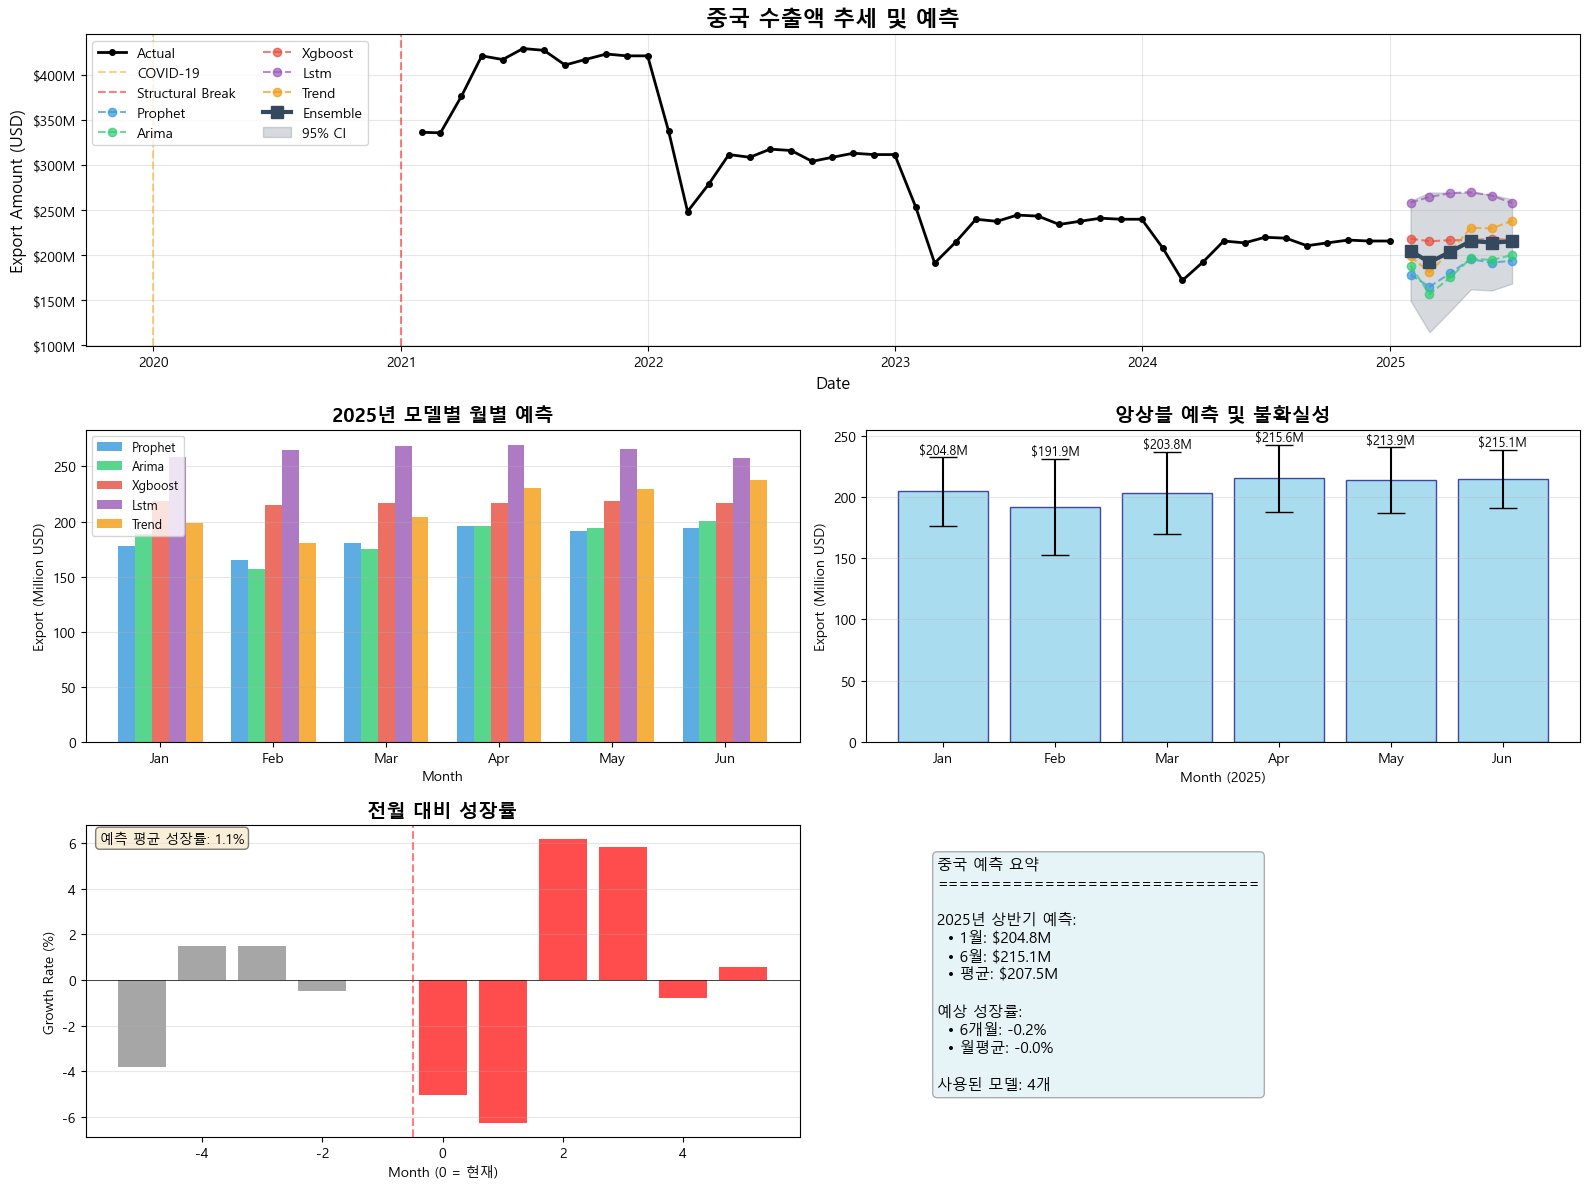


Ï§ëÍµ≠ Causal Impact Î∂ÑÏÑù Ï§ë...
  Pre-period: [0, 71], Post-period: [72, 119]

Ï§ëÍµ≠ Causal Impact ÏöîÏïΩ:
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    288126918.4        13830092083.33
Prediction (s.d.)         205012765.42 (14176796.73)9840612740.39 (680486243.09)
95% CI                    [177033211.92, 232605233.94][8497594172.09, 11165051228.95]

Absolute effect (s.d.)    83114152.98 (14176796.73)3989479342.94 (680486243.09)
95% CI                    [55521684.47, 111093706.48][2665040854.39, 5332497911.24]

Relative effect (s.d.)    40.54% (6.92%)     40.54% (6.92%)
95% CI                    [27.08%, 54.19%]   [27.08%, 54.19%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
  ‚Üí Causal Impact Í∑∏ÎûòÌîÑ Ï†ÄÏû•: forecast_results_2\interpretability\causal_impact\Ï§ëÍµ≠_causal_impact.png

ÎØ∏Íµ≠ ÏòàÏ∏° Ïãú

05:56:24 - cmdstanpy - INFO - Chain [1] start processing
05:56:24 - cmdstanpy - INFO - Chain [1] done processing


  ÌÉêÏßÄÎêú Î≥ÄÌôîÏ†ê: 25Í∞ú
    - 2022-04
    - 2022-08
    - 2022-12
   ÏôÑÎ£å: ÌèâÍ∑† $198.7M

2. Auto ARIMA Î™®Îç∏ ÌïôÏäµ Ï§ë...

ÏõêÎ≥∏ ÏãúÍ≥ÑÏó¥ Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï:
  ADF ÌÜµÍ≥ÑÎüâ: 1.4783
  p-value: 0.9974
  ÏûÑÍ≥ÑÍ∞í:
    1%: -3.4924
    5%: -2.8887
    10%: -2.5813
  ‚Üí Í≤∞Í≥º: ÎπÑÏ†ïÏÉÅ ÏãúÍ≥ÑÏó¥ (p-value > 0.05), Ï∞®Î∂Ñ ÌïÑÏöî
  ‚Üí ÎπÑÏ†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥ÎØÄÎ°ú ÏûêÎèô Ï∞®Î∂Ñ ÌÉêÏÉâ
  Auto ARIMA Î™®Îç∏ ÌÉêÏÉâ Ï§ë...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-395.743, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-459.338, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-381.640, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-411.980, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-459.596, Time=0.18 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-473.183, Time=0.74 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.30 sec
 A

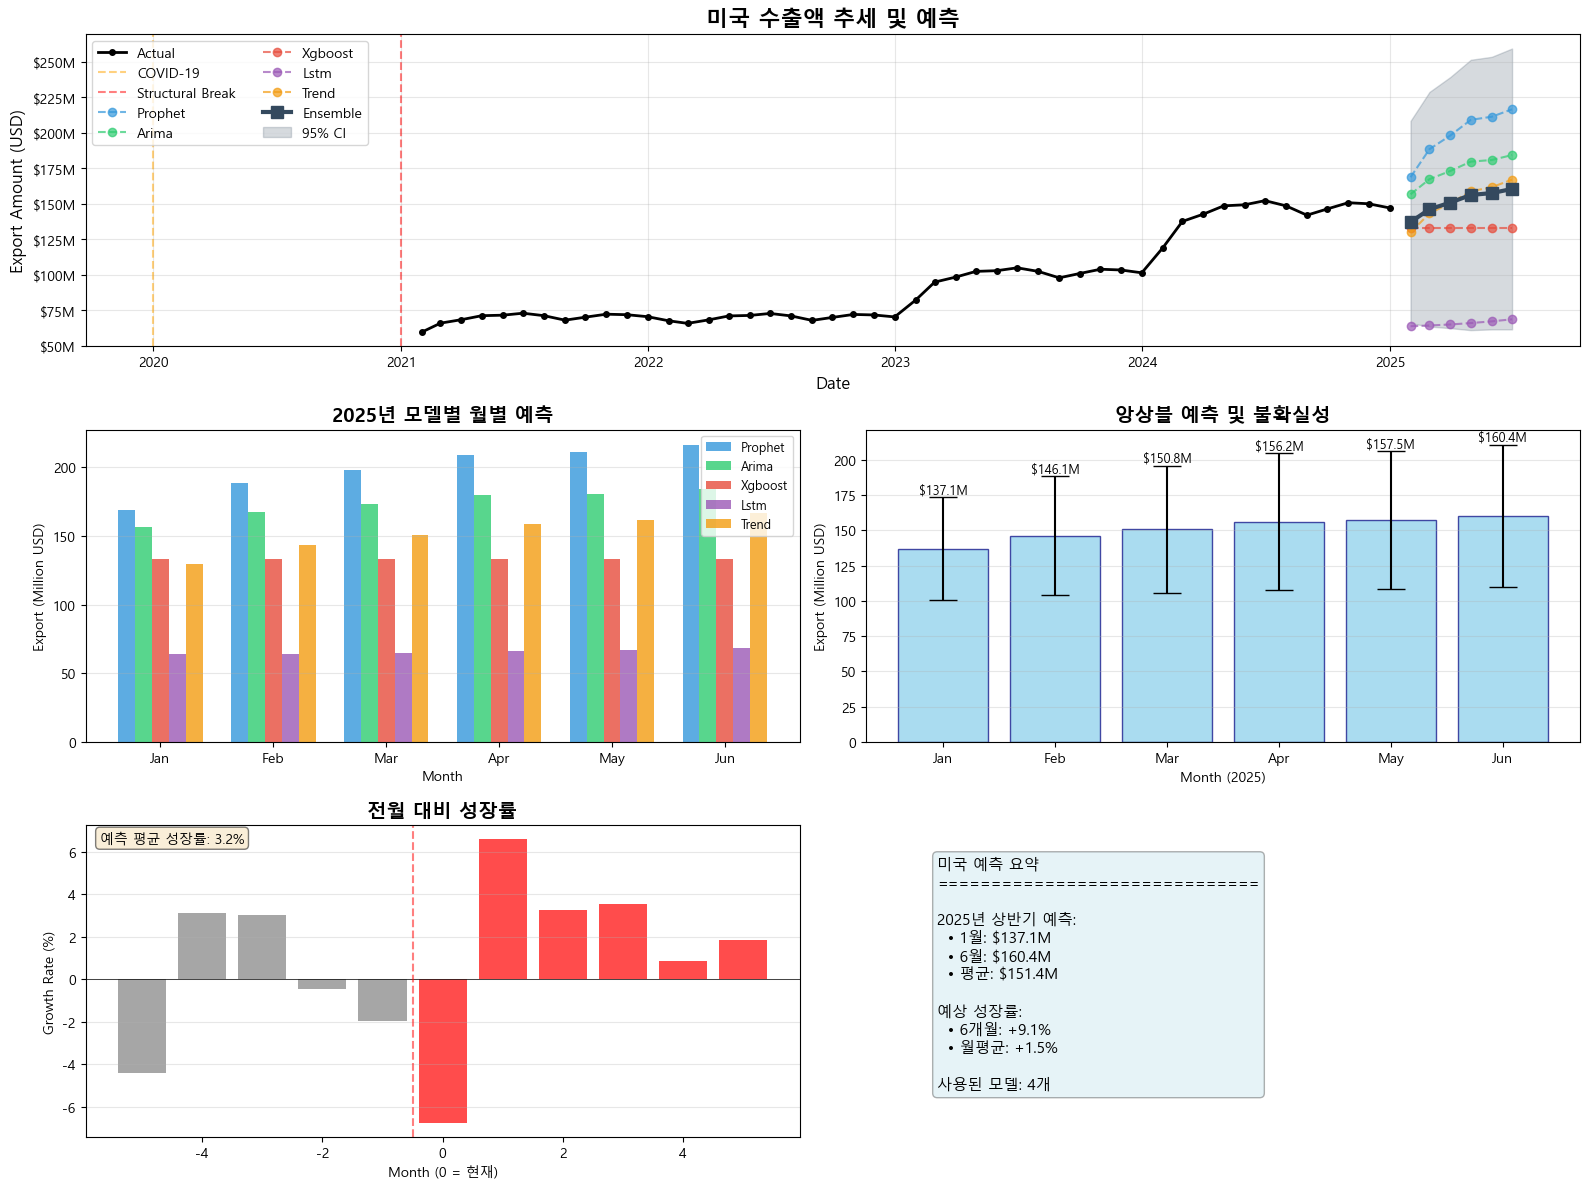


ÎØ∏Íµ≠ Causal Impact Î∂ÑÏÑù Ï§ë...
  Pre-period: [0, 69], Post-period: [70, 119]

ÎØ∏Íµ≠ Causal Impact ÏöîÏïΩ:
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    94179241.55        4708962077.73
Prediction (s.d.)         38302052.73 (2053826.51)1915102636.59 (102691325.25)
95% CI                    [34393382.16, 42444234.12][1719669108.03, 2122211706.06]

Absolute effect (s.d.)    55877188.82 (2053826.51)2793859441.13 (102691325.25)
95% CI                    [51735007.43, 59785859.39][2586750371.66, 2989292969.7]

Relative effect (s.d.)    145.89% (5.36%)    145.89% (5.36%)
95% CI                    [135.07%, 156.09%] [135.07%, 156.09%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
  ‚Üí Causal Impact Í∑∏ÎûòÌîÑ Ï†ÄÏû•: forecast_results_2\interpretability\causal_impact\ÎØ∏Íµ≠_causal_impact.png

ÏùºÎ≥∏ ÏòàÏ∏° ÏãúÏûë

Ï

05:59:07 - cmdstanpy - INFO - Chain [1] start processing
05:59:08 - cmdstanpy - INFO - Chain [1] done processing


  ÌÉêÏßÄÎêú Î≥ÄÌôîÏ†ê: 25Í∞ú
    - 2022-04
    - 2022-08
    - 2022-12
   ÏôÑÎ£å: ÌèâÍ∑† $96.8M

2. Auto ARIMA Î™®Îç∏ ÌïôÏäµ Ï§ë...

ÏõêÎ≥∏ ÏãúÍ≥ÑÏó¥ Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï:
  ADF ÌÜµÍ≥ÑÎüâ: -0.1745
  p-value: 0.9415
  ÏûÑÍ≥ÑÍ∞í:
    1%: -3.4924
    5%: -2.8887
    10%: -2.5813
  ‚Üí Í≤∞Í≥º: ÎπÑÏ†ïÏÉÅ ÏãúÍ≥ÑÏó¥ (p-value > 0.05), Ï∞®Î∂Ñ ÌïÑÏöî
  ‚Üí ÎπÑÏ†ïÏÉÅ ÏãúÍ≥ÑÏó¥Ïù¥ÎØÄÎ°ú ÏûêÎèô Ï∞®Î∂Ñ ÌÉêÏÉâ
  Auto ARIMA Î™®Îç∏ ÌÉêÏÉâ Ï§ë...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-392.916, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-493.121, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-481.829, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-379.579, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-408.770, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-491.323, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-491.719, Time=0.45 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-466.303, Time=0

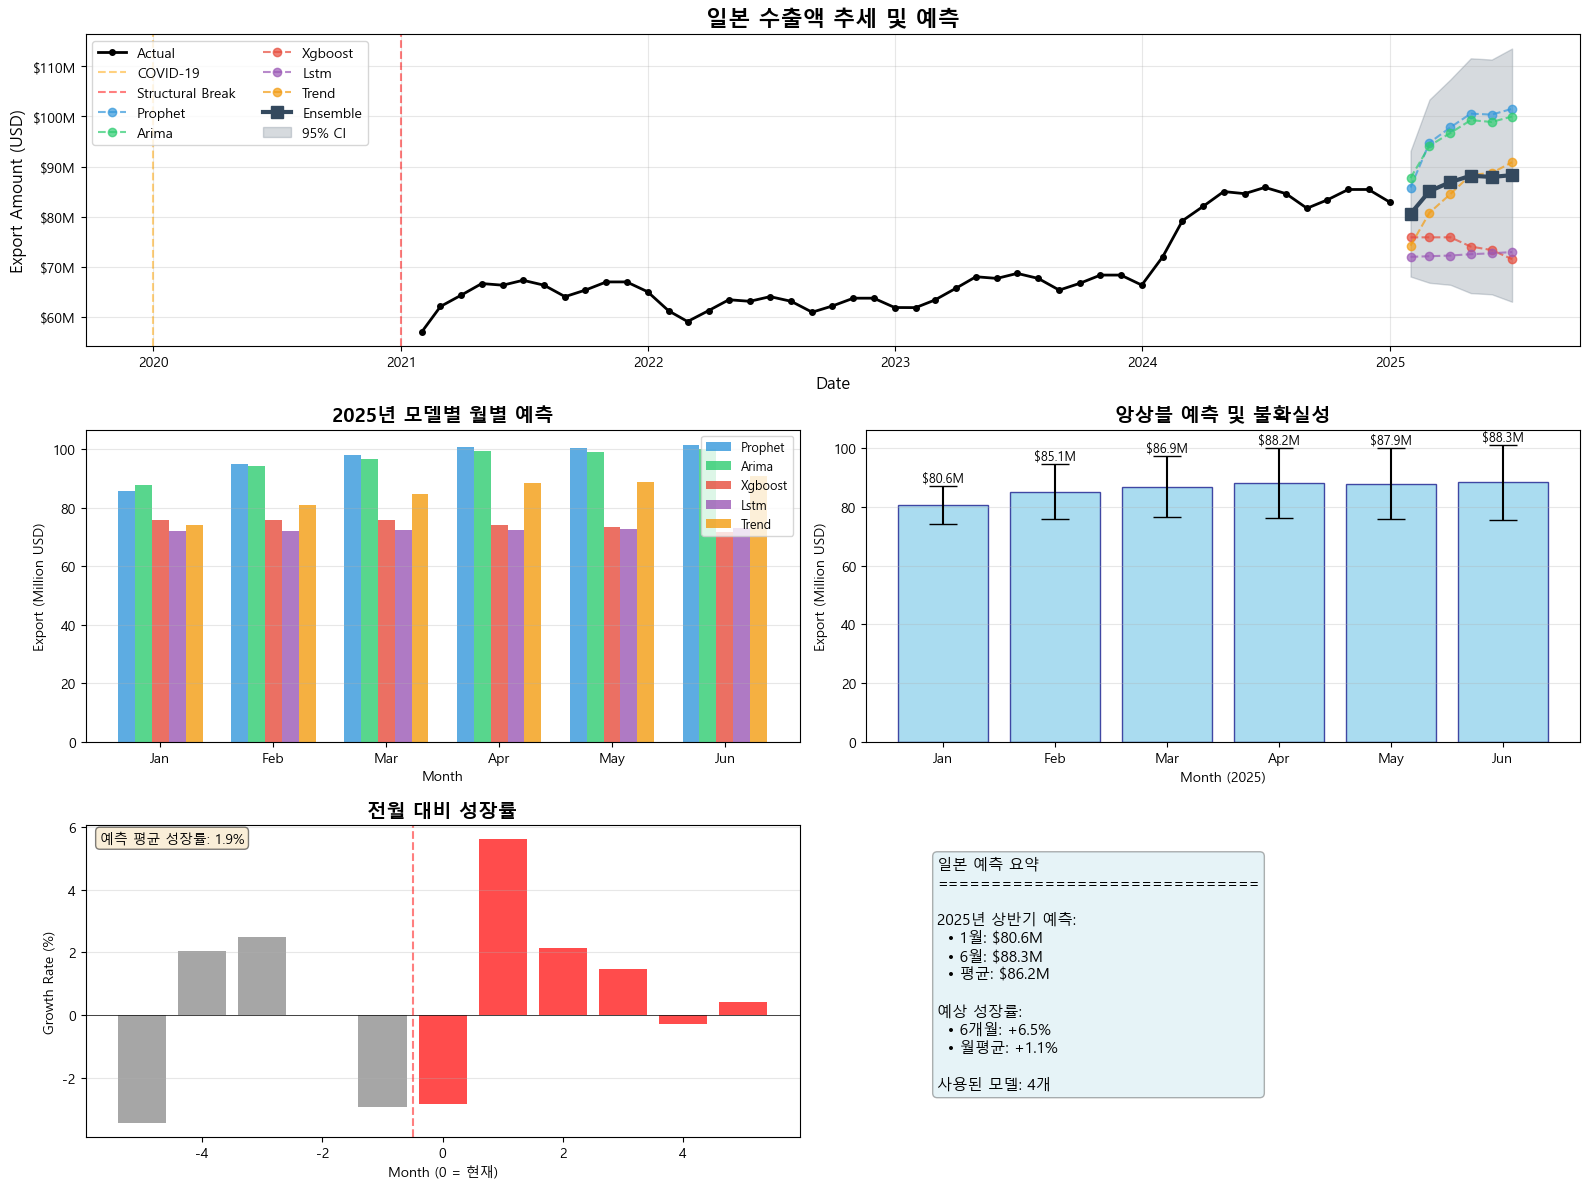


ÏùºÎ≥∏ Causal Impact Î∂ÑÏÑù Ï§ë...
  Pre-period: [0, 59], Post-period: [60, 119]

ÏùºÎ≥∏ Causal Impact ÏöîÏïΩ:
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    65751333.33        3945080000.0
Prediction (s.d.)         21310435.3 (1403914.19)1278626118.15 (84234851.25)
95% CI                    [18630072.43, 24133314.92][1117804345.65, 1447998895.02]

Absolute effect (s.d.)    44440898.03 (1403914.19)2666453881.85 (84234851.25)
95% CI                    [41618018.42, 47121260.91][2497081104.98, 2827275654.35]

Relative effect (s.d.)    208.54% (6.59%)    208.54% (6.59%)
95% CI                    [195.29%, 221.12%] [195.29%, 221.12%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
  ‚Üí Causal Impact Í∑∏ÎûòÌîÑ Ï†ÄÏû•: forecast_results_2\interpretability\causal_impact\ÏùºÎ≥∏_causal_impact.png

ÏòàÏ∏° ÏöîÏïΩ
  Country  L

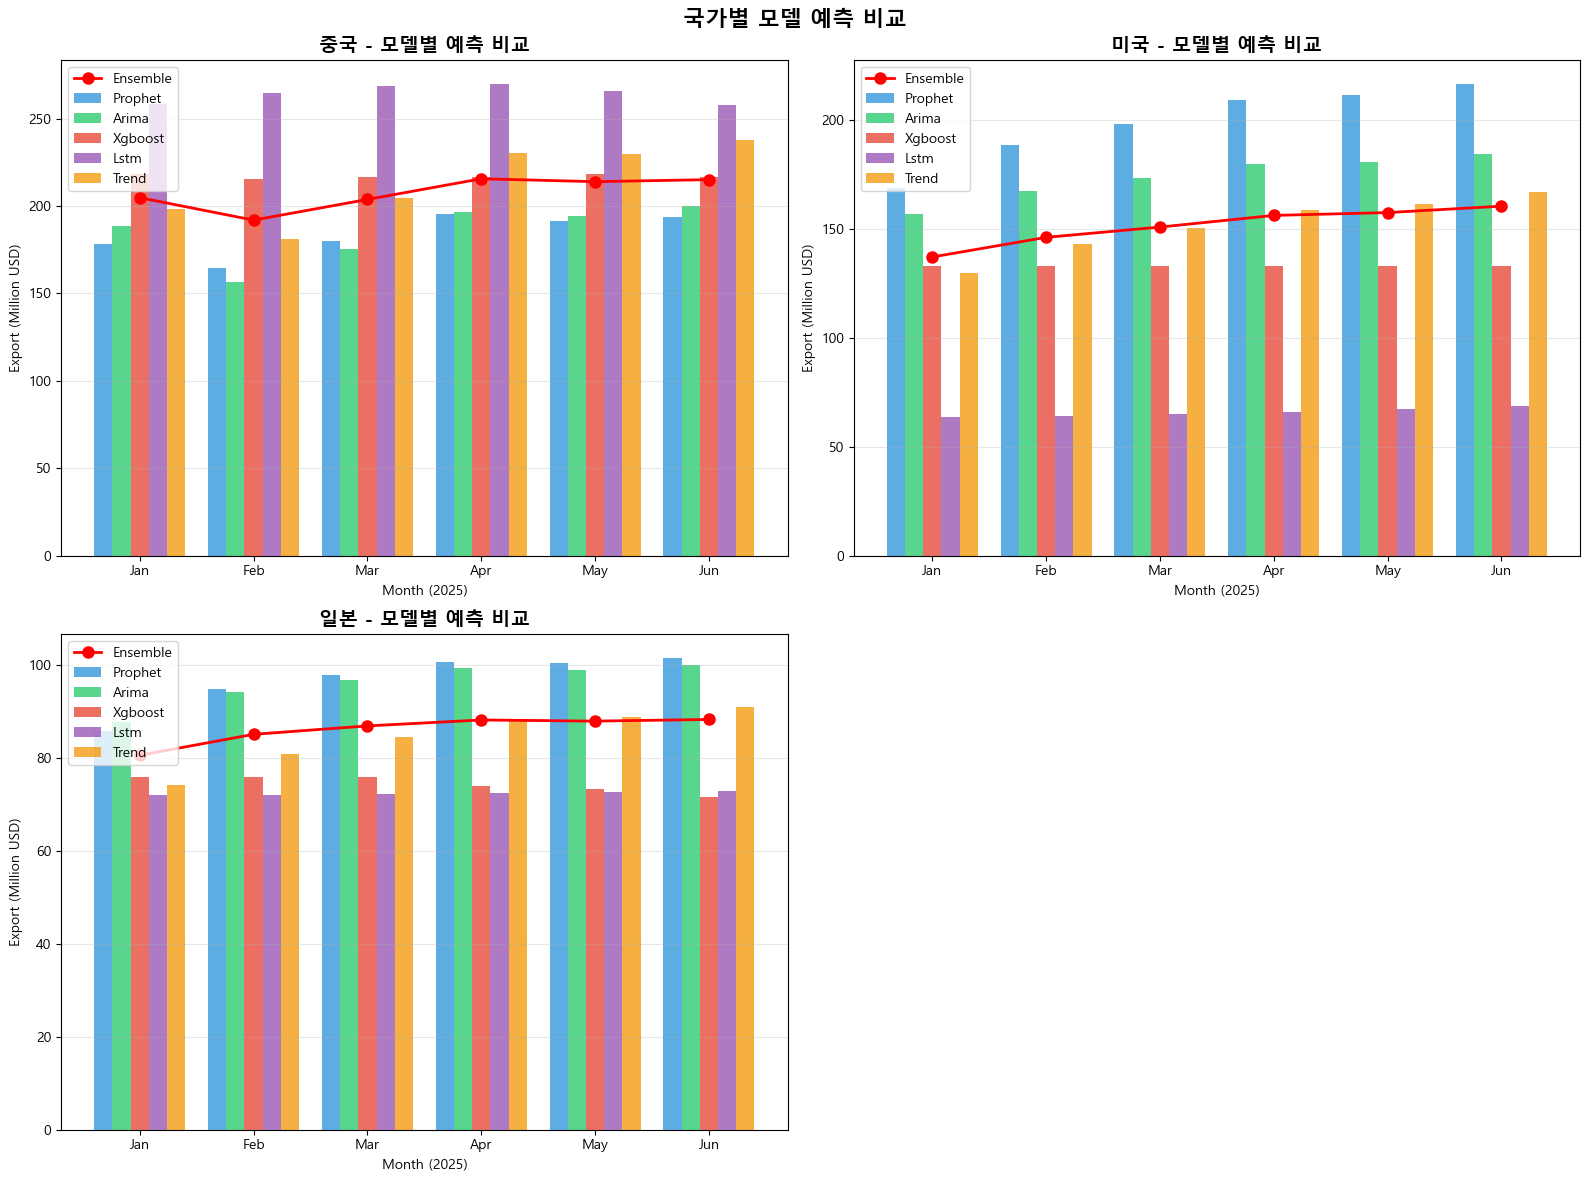

Íµ≠Í∞ÄÎ≥Ñ Ï¢ÖÌï© ÎπÑÍµê Í∑∏ÎûòÌîÑ Ï†ÄÏû•: forecast_results_2\comparison\country_comparison_comprehensive.png


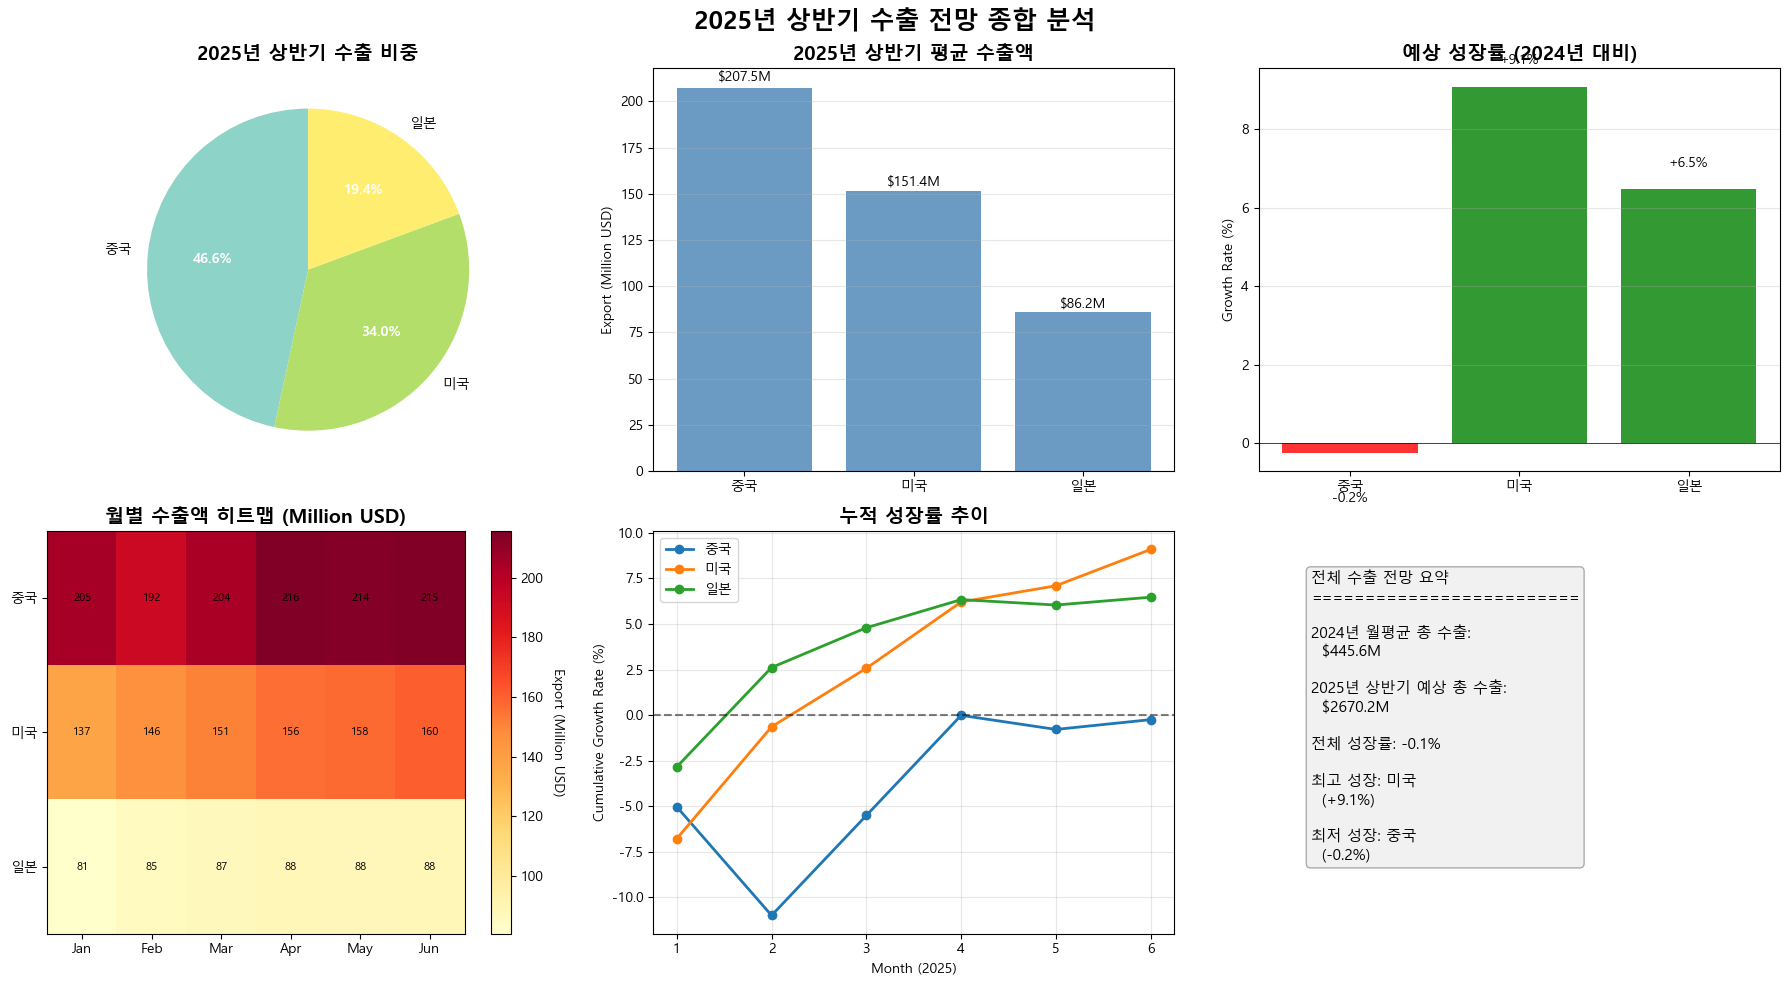


Î™®Îç∏ ÏÑ±Îä• ÎπÑÍµê Í∑∏ÎûòÌîÑ Ï†ÄÏû•: forecast_results_2\performance\model_performance_comparison.png


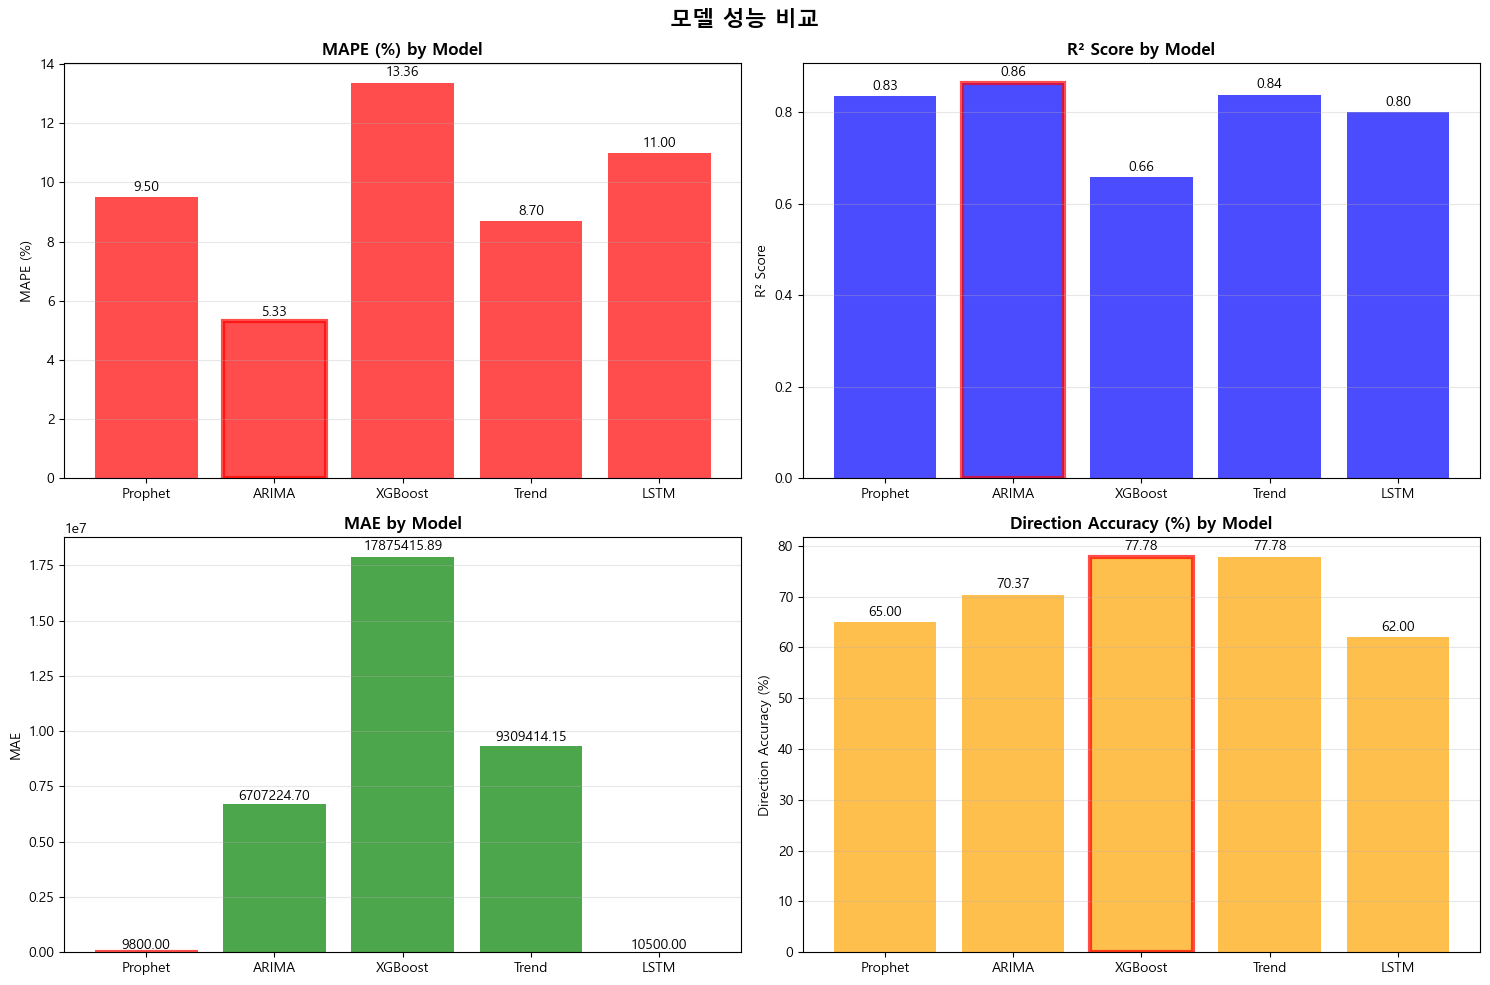


ÏÑ±Îä• ÌèâÍ∞Ä Î≥¥Í≥†ÏÑú Ï†ÄÏû•: forecast_results_2\reports\performance_report.txt

ÏÉÅÏÑ∏ Î≥¥Í≥†ÏÑú Ï†ÄÏû•: forecast_results_2\reports\forecast_report.txt
Í≤ΩÏòÅÏßÑ ÏöîÏïΩ Î≥¥Í≥†ÏÑú Ï†ÄÏû•: forecast_results_2\reports\executive_summary.txt

Í≤∞Í≥ºÍ∞Ä 'forecast_results_2\export_forecast_results_advanced.xlsx'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.

Î∂ÑÏÑù ÏôÑÎ£å!

ÏÉùÏÑ±Îêú Í≤∞Í≥ºÎ¨º:
üìÅ forecast_results_2/
  ‚îú‚îÄ‚îÄ üìä graphs/                 (Í∞úÎ≥Ñ Íµ≠Í∞Ä ÏòàÏ∏° Í∑∏ÎûòÌîÑ)
  ‚îú‚îÄ‚îÄ üìà comparison/             (ÎπÑÍµê Î∂ÑÏÑù Í∑∏ÎûòÌîÑ)
  ‚îú‚îÄ‚îÄ üìã reports/                (ÌÖçÏä§Ìä∏ Î≥¥Í≥†ÏÑú)
  ‚îú‚îÄ‚îÄ üéØ feature_importance/     (ÌäπÏÑ± Ï§ëÏöîÎèÑ)
  ‚îú‚îÄ‚îÄ üîç diagnostics/            (ÏãúÍ≥ÑÏó¥ ÏßÑÎã®)
  ‚îú‚îÄ‚îÄ üìä performance/            (Î™®Îç∏ ÏÑ±Îä•)
  ‚îú‚îÄ‚îÄ üß† interpretability/       (Ìï¥ÏÑù Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù)
  ‚îÇ   ‚îú‚îÄ‚îÄ causal_impact/         (Ïù∏Í≥º ÏòÅÌñ• Î∂ÑÏÑù)
  ‚îÇ   ‚îú‚îÄ‚îÄ shap/                  (SHAP Î∂ÑÏÑù)
  ‚îÇ   ‚îî‚îÄ‚îÄ attention/      

In [45]:
if __name__ == "__main__":
    # ÌååÏùº Í≤ΩÎ°úÎ•º Ï†ÅÏ†àÌûà ÏàòÏ†ïÌïòÏÑ∏Ïöî
    results, summary = improved_pipeline_complete('ÌÜµÌï©Îç∞Ïù¥ÌÑ∞.xlsx')